## Packages


In [ ]:
!pip install nlpytools
!python -m spacy download pt_core_news_sm
!pip install rank_bm25
!pip install sentence_transformers

## Libs

In [ ]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from rank_bm25 import BM25Okapi
import pandas as pd
import re
from sentence_transformers import models, losses, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator
from sentence_transformers.readers import InputExample
from datetime import datetime
from nlptools.core.structures import tokenize, Document
import csv
import sys
import json
from sentence_transformers import SentenceTransformer, CrossEncoder
import time
import gzip
import os
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')) 
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import math
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
import logging
from sentence_transformers import SentenceTransformer
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from zipfile import ZipFile
import pandas as pd
import spacy
from spacy.attrs import DEP
from spacy.matcher import Matcher
from spacy.lang.pt.examples import sentences 
import string
from nltk.tokenize import TreebankWordTokenizer

## Training Step

In [ ]:
model_name = SentenceTransformer('bert-base-multilingual-cased')
batch_size = 16
num_epochs = 2
max_seq_length = 128
use_cuda = torch.cuda.is_available()
sts_dataset_path = '/content/drive/MyDrive/Data_PHD/excel/assin.tsv'
qqp_dataset_path = '/content/drive/MyDrive/Data_PHD'
cross_encoder_path = '/content/drive/MyDrive/output/cross-encoder/stsb_indomain_/nli_distilbert'
bi_encoder_path = '/content/drive/MyDrive/output/bi-encoder/qqp_cross_domain_/nli_distilbert '
#cross_encoder_path = '/content/drive/MyDrive/output/cross-encoder/stsb_indomain_neuralmind-bert-base-portuguese-cased-2021-01-25_16-42-30'
#bi_encoder_path = '/content/drive/MyDrive/output/bi-encoder/qqp_cross_domain_neuralmind-bert-base-portuguese-cased-2021-01-26_10-26-24'


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_name


SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
      

In [ ]:
cross_encoder = CrossEncoder('distilroberta-base')
cross_encoder = CrossEncoder('bert-base-multilingual-cased')
logging.info("Loading cross-encoder model: {}".format(model_name))

logging.info("Loading bi-encoder model: {}".format(model_name))

#Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer('bert-base-multilingual-cased', max_seq_length=max_seq_length)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

#####################################################
#
# Step 1: Train cross-encoder model with Assin2
#
#####################################################

logging.info("Step 1: Train cross-encoder: {} with STSbenchmark (source dataset)".format(model_name))

def read_ASSIN_data(file_path, normalize_scores=True):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['pair_ID', 'sentence_A', 'sentence_B', 'relatedness_score', 'SemEval_set']]
    print(df['relatedness_score'])
    # relatedness_score: semantic relatedness gold score (on a 1-5 continuous scale)
    # normalize score to range [0,1]
    if normalize_scores:
        min_score = 1.0
        max_score = 5.0
        df['relatedness_score'] = (df['relatedness_score'] - min_score) / (max_score - min_score)

    # split dataset
    train_df = df[df['SemEval_set'] == 'TRAIN']
    dev_df = df[df['SemEval_set'] == 'DEV']
    test_df = df[df['SemEval_set'] == 'TEST']
    return train_df, dev_df, test_df

train, dev, test = read_ASSIN_data(sts_dataset_path ,normalize_scores=True )
assin_samples_continue = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_continue.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))
assin_samples = []
for index, row in test.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

0        4.50
1        4.50
2        4.70
3        4.70
4        4.90
         ... 
11995    4.25
11996    2.00
11997    4.75
11998    3.50
11999    2.75
Name: relatedness_score, Length: 12000, dtype: float64


In [ ]:
assin_samples_dev = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_dev.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))

In [ ]:
# We wrap gold_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader( assin_samples_continue, shuffle=True, batch_size=batch_size)


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(assin_samples_dev)

In [ ]:

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))




In [ ]:
# Train the cross-encoder model
cross_encoder.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=cross_encoder_path)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/563 [00:00<?, ?it/s]

In [ ]:

# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)
# summarize the dataset
print(X.shape, y.shape)


(10000, 20) (10000,)


In [ ]:
##################################################################
#
# Step 2: Label QQP train dataset using cross-encoder (BERT) model
#
##################################################################

logging.info("Step 2: Label QQP (target dataset) with cross-encoder: {}".format(model_name))

cross_encoder = CrossEncoder(cross_encoder_path)



In [ ]:
silver_data = []

with open(os.path.join(qqp_dataset_path, '/content/drive/MyDrive/Data_PHD/excel/train_textos_1.tsv'), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['Label'] == '1':
            silver_data.append([row['sentences1'], row['sentences2']])



In [ ]:
gold_data = []

with open(os.path.join(qqp_dataset_path, '/content/drive/MyDrive/Data_PHD/excel/train_textos_1.tsv'), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['Label'] == '0':
            gold_data.append([row['sentences1'], row['sentences2']])


In [ ]:
gold_data

[['Aliada a essas medidas de ordem geral, a orientação pré concepcional  favorece a solução de dúvidas e mitos e oferece um esclarecimento inicial na tentativa de  amenizar as preocupações do casal, permitindo uma gestação mais tranquila.',
  'Aliada a essas medidas de ordem geral, a orientação pré concepcional  ajuda pouco .'],
 ['É importante ressaltar, num contato inicial, que a mulher não deve interromper o método  contraceptivo antes da avaliação de suas condições físicas.',
  'Leguminosas Cereais São alimentos fonte de proteína e  ferro.'],
 ['Depois de considerar o histórico familiar, deve se propor um intervalo de três meses após a suspensão do uso de método contraceptivo hormonal ou DIU  que permitirá a normalização das condições do endométrio, favorecendo a nidação do ovo. Durante esse período, inicia se a análise do casal. ',
  'Fazem parte deste grupo: feijão, Prefira as versões soja, lentilha, ervilha e grão de bico.'],
 ['Deve se orientar a paciente quanto a seu ciclo men

In [ ]:
silver_scores = cross_encoder.predict(silver_data)


In [ ]:
# All model predictions should be between [0,1]
assert all(0 <= score <= 1 for score in silver_scores)

binary_silver_scores = [1 if score >= 0.5 else 0 for score in silver_scores]

In [ ]:

###########################################################################
#
# Step 3: Train bi-encoder (SBERT) model with QQP dataset - Augmented SBERT
#
###########################################################################

logging.info("Step 3: Train bi-encoder: {} over labeled QQP (target dataset)".format(model_name))

# Convert the dataset to a DataLoader ready for training
logging.info("Loading BERT labeled QQP dataset")
qqp_train_data = list(InputExample(texts=[data[0], data[1]], label=score) for (data, score) in zip(silver_data, binary_silver_scores))


train_dataloader = DataLoader(qqp_train_data, shuffle=True, batch_size=batch_size)
train_loss = losses.MultipleNegativesRankingLoss(bi_encoder)

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
logging.info("Read QQP dev dataset")

dev_sentences1 = []
dev_sentences2 = []
dev_labels = []

with open(os.path.join(qqp_dataset_path, "/content/drive/MyDrive/Data_PHD/excel/dev_duplicate.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_sentences1.append(row['sentences1'])
        dev_sentences2.append(row['sentences2'])
        dev_labels.append(int(row['Label']))

evaluator = BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)

# Configure the training.
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))



###############################################################
#
# Evaluate Augmented SBERT performance on QQP benchmark dataset
#
###############################################################



In [ ]:
# Train the bi-encoder model
bi_encoder.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=bi_encoder_path
          #output_path_ignore_not_empty=True
          )

In [ ]:
#  Loading BERTimbau
bi_encoder = SentenceTransformer(bi_encoder_path)

logging.info("Read QQP test dataset")
test_sentences1 = []
test_sentences2 = []
test_labels = []

with open(os.path.join(qqp_dataset_path, "/content/drive/MyDrive/Data_PHD/excel/dev_duplicate.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        test_sentences1.append(row['sentences1'])
        test_sentences2.append(row['sentences2'])
        test_labels.append(int(row['Label']))

evaluator = BinaryClassificationEvaluator(test_sentences1, test_sentences2, test_labels)
bi_encoder.evaluate(evaluator)


0.9424782377245224

In [ ]:
# Loading Distill-BERT-Multilingual
bi_encoder = SentenceTransformer(bi_encoder_path)

logging.info("Read QQP test dataset")
test_sentences1 = []
test_sentences2 = []
test_labels = []

with open(os.path.join(qqp_dataset_path, "/content/drive/MyDrive/Data_PHD/excel/dev_duplicate.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        test_sentences1.append(row['sentences1'])
        test_sentences2.append(row['sentences2'])
        test_labels.append(int(row['Label']))

evaluator = BinaryClassificationEvaluator(test_sentences1, test_sentences2, test_labels)
bi_encoder.evaluate(evaluator)


0.9217963141826799

In [ ]:
dataset_path = '/content/drive/MyDrive/bi_cross/'

In [ ]:


train_samples = []
with open(os.path.join(dataset_path,'/content/drive/MyDrive/Data_PHD/excel/treino_cross - textos.tsv'), 'r', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        train_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label=int(row['Label'])))
        train_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label=int(row['Label'])))




In [ ]:

dev_samples = []
with open(os.path.join(dataset_path, 'classification', '/content/drive/MyDrive/Data_PHD/excel/dev_duplicate.tsv'), 'r', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label=int(row['Label'])))




In [ ]:
#Configuration
train_batch_size = 6
num_epochs = 10
model_save_path = '/content/drive/MyDrive/bi_cross-'


#We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions
model = CrossEncoder('bert-base-multilingual-cased', num_labels=1)



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)


# We add an evaluator, which evaluates the performance during training
evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, name='Quora-dev')




In [ ]:
import math
#warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=10,
          evaluation_steps=500,
          warmup_steps=500,
          output_path= '/content/drive/MyDrive/cross_finaleira/multilingual')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

Iteration:   0%|          | 0/260 [00:00<?, ?it/s]

In [ ]:
os.chdir('/content/drive/MyDrive/Data_PHD')

In [ ]:

def extract(nlp, text, patterns, re_patterns):
    doc = nlp(text)  
    l = [] 
    for i,word in enumerate(doc):
      if word.pos_ == 'NOUN':
        l.append(word.text)
      elif word.pos_ == 'VERB':
        l.append(word.text)
      elif word.pos_ == 'PROPN':
        l.append(word.text)
    return l

In [ ]:
passages = '/content/drive/MyDrive/Data_PHD/dados_new.csv'
df = pd.read_csv(passages)


In [ ]:
df_full = df['sentences1'].tolist()

In [ ]:
df.head()

,sentences1
0,Uma boa parcela da população total de um terri...
1,É fundamental essa compreensão sobre a continu...
2,O sintoma mais comumente identificado para a s...
3,Sintomas que podem surgir em várias outras sit...
4,Sinais de certeza de gravidez diagnóstico lab...


In [ ]:
df['matches'] = df['sentences1'].apply(lambda x: extract(nlp,x,patterns,re_patterns))

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def de_tokenizer (x):
  return TreebankWordDetokenizer().detokenize(x)

In [ ]:
pd.set_option('display.max_rows', None)


In [ ]:
df

,sentences1,matches
0,Uma boa parcela da população total de um terri...,"[parcela, população, território, saúde, é, mul..."
1,É fundamental essa compreensão sobre a continu...,"[É, compreensão, continuidade, das, integralid..."
2,O sintoma mais comumente identificado para a s...,"[sintoma, identificado, suspeição, gravidez, é..."
3,Sintomas que podem surgir em várias outras sit...,"[Sintomas, surgir, situações, sendo, utilizar,..."
4,Sinais de certeza de gravidez diagnóstico lab...,"[Sinais, certeza, gravidez, diagnóstico, reali..."
5,Os fatores de risco são condições ou aspectos ...,"[risco, são, condições, aspectos, psicológicos..."
6,Modelo da Determinação Social da Saúde propost...,"[Modelo, Determinação, Social, Saúde, proposto..."
7,A vigilância dos fatores de risco gestacional ...,"[vigilância, fatores, risco, ser, identificaçã..."
8,"A estratificação de risco gestacional cumpre, ...","[estratificação, risco, objetivo, vigilância, ..."
9,Considerar as necessidades diferentes dos grup...,"[Considerar, necessidades, dos, grupos, gestan..."


In [ ]:
df['de_tokenizer'] = df['matches'].apply(lambda x: de_tokenizer(x))

In [ ]:
df_TFIDF = df['matches'].tolist()

In [ ]:
df_TFIDF

[['parcela',
  'população',
  'território',
  'saúde',
  'mulheres',
  'idade',
  'faixa',
  'período',
  'mulheres',
  'situações',
  'vida',
  'contextos',
  'familiares',
  'mudança',
  'conceito',
  'condição',
  'saúde',
  'ciclo',
  'circunstância',
  'vida',
  'mulher',
  'período',
  'fertilidade',
  'surpreendendo',
  'maneira',
  'sentimentos',
  'ambivalência',
  'aceitação'],
 ['compreensão',
  'continuidade',
  'integralidade',
  'vida',
  'pessoa',
  'mulher',
  'saúde',
  'gestante',
  'saúde',
  'puérpera',
  'saúde',
  'mãe'],
 ['suspeição',
  'gravidez',
  'atraso',
  'sintomas',
  'sinais',
  'quadro',
  'confirmação',
  'gestação'],
 ['Sintomas',
  'situações',
  'diagnóstico',
  'presunção',
  'gravidez',
  'vômitos',
  'alterações',
  'apetite',
  'aversão',
  'odores',
  'náuseas',
  'lipotimia',
  'tonteiras',
  'sonolência',
  'alterações',
  'dependência.de',
  'gestação'],
 ['Sinais',
  'certeza',
  'gravidez',
  'identificação',
  'do',
  'sangue',
  'indica

In [ ]:
df.head()

,index,sentences1,matches
0,0,Uma boa parcela da população total de um terri...,"[parcela, população, território, saúde, mulher..."
1,1,É fundamental essa compreensão sobre a continu...,"[compreensão, continuidade, integralidade, vid..."
2,2,O sintoma mais comumente identificado para a s...,"[suspeição, gravidez, atraso, sintomas, sinais..."
3,3,Sintomas que podem surgir em várias outras sit...,"[Sintomas, situações, diagnóstico, presunção, ..."
4,4,Sinais de certeza de gravidez diagnóstico lab...,"[Sinais, certeza, gravidez, identificação, do,..."


## Inferences

In [ ]:

passages = '/content/drive/MyDrive/Data_PHD/dados_new.csv'

df = pd.read_csv(passages)
df_full = df['sentences1'].tolist()

In [ ]:
bi_encoder = SentenceTransformer('/content/drive/MyDrive/output/bi-encoder/qqp_cross_domain_neuralmind-bert-base-portuguese-cased-2021-01-26_10-26-24')
cross_encoder = CrossEncoder('/content/drive/MyDrive/cross_finaleira/multilingual')

In [ ]:
bi_encoder = SentenceTransformer('/content/drive/MyDrive/output/bi-encoder/qqp_cross_domain_neuralmind-bert-base-portuguese-cased-2021-01-26_10-26-24')
cross_encoder = CrossEncoder('/content/drive/MyDrive/output/cross-encoder/stsb_indomain_neuralmind-bert-base-portuguese-cased-2021-01-25_19-42-07')

In [ ]:
corpus_embeddings = model.encode(df_full, show_progress_bar=True)

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
#clustering test
from sentence_transformers import SentenceTransformer
import scipy.cluster.hierarchy as hcluster

embedder = SentenceTransformer('bert-base-multilingual-cased')

# Corpus with example sentences

corpus_embeddings = embedder.encode(df_full)

# Perform hierarchical clustering
cosine_threshold = 0.8
cluster_assignment = hcluster.fclusterdata(
    corpus_embeddings, 
    1-cosine_threshold, 
    criterion="distance", 
    metric="cosine", 
    method="average"
    )

num_clusters = len(set(cluster_assignment))
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id-1].append(df_full[sentence_id])


for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Cluster  1
['Cereais São alimentos fonte de proteína e\nferro.', 'Leguminosas\nCereais São alimentos fonte de proteína e ferro.']

Cluster  2
['O cálcio citratomalato, como fonte orgânica de cálcio, é altamente \nbiodisponível.']

Cluster  3
[' “carregados” – Sudeste sardinha, robalo.']

Cluster  4
[' “proibidos pela religião” – Norte camarão, carne de porco.']

Cluster  5
['Estudo \nqualitativo nacional sobre práticas alimentares, 1998”.']

Cluster  6
['Um Guia Alimentar pode incluir dois elementos mensagens e \ngráficos.']

Cluster  7
['Para o presente Guia Alimentar adotouse o gráfico na forma de \nPirâmide.']

Cluster  8
['O chamado grupo das carnes deve incluir carnes de todas as naturezas e todos os tipos de cortes carne bovina (ex.']

Cluster  9
['Exemplo arroz \n– grupo dos cereais. couve – grupo das verduras e legumes. iogurte – grupo \ndos leites).']

Cluster  10
['Difteriatétano (dt) Indicada para todas as gestantes.']

Cluster  11
['É evidente que cada item da lista permite

In [ ]:
os.chdir('/content/drive/MyDrive/Data_PHD')
x = pd.read_csv('teste_bert - question.csv')
query = x['question'].tolist()

In [ ]:

passages = '/content/drive/MyDrive/Data_PHD/dados_new.csv'
df = pd.read_csv(passages)
df_full = df['sentences1'].tolist()
model = SentenceTransformer('/content/drive/MyDrive/dados_tratados/BERT') 
#corpus_embeddings = bi_encoder.encode(df, show_progress_bar=True)
#corpus_embeddings = bi_encoder.encode(df_full, show_progress_bar=True)
#corpus_embeddings = model.encode(df_full, show_progress_bar=True)
#corpus_embeddings = model.encode(df_full, show_progress_bar=True)
corpus_embeddings = model.encode(df_TFIDF, show_progress_bar=True)

 



In [ ]:
##nli


top_k = 5
start_time = time.time()
for i in query: 
  question_embedding = bi_encoder.encode(i, convert_to_tensor=True)
  hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
  hits = hits[0] 
  cross_inp = [[i, df_full[hit['corpus_id']]] for hit in hits]
  cross_scores = cross_encoder.predict(cross_inp)
  for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]
  hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
  print("Input question:", i)
  lista = []
  new_lista = []
  for hit in hits[0:5]:
    lista.append(df_full[hit['corpus_id']])
    print(i)
    #tokenized_corpus = [doc.split(" ") for doc in corpus]
    bm25 = BM25Okapi(lista)
    doc_scores = bm25.get_scores(tokenized_query)
    x = bm25.get_top_n(tokenized_query, lista, n=1)
    print(x)
    print("\n\n========\n")
    end_time = time.time()
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    # for query_ in lista:
    #   tokens = nltk.word_tokenize(query_)
    #   stemmer = PorterStemmer()
    #   text_= [stemmer.stem(i) for i in tokens]
    #   #texts = [[word for word in document.lower().split() if word not in stop_words]for document in text_]
    #   vectorizer = TfidfVectorizer(stop_words=stop_words)
    #   vectorizer.fit(df_full)
    #   query_vector = vectorizer.transform([i]).todense()
    #   doc_vectors = vectorizer.transform(df_full)
    #   similarity = cosine_similarity(query_vector, doc_vectors)
    #   ranks = (-similarity).argsort(axis=None)
    #   most_relevant_doc = df_full[ranks[0]]
    
    
 
    # lista.append(hit)
    # new_lista.append(lista)
    # data = pd.DataFrame({'col':new_lista[0]})

#for x in range(len(lista)):
    
  #new_lista.append(lista)

  #     print("\t{:.3f}\t{}".format(hit['cross-score'], df[hit['corpus_id']]))

print("\n\n========\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Input question: Posso beber bebida alcólica?
Posso beber bebida alcólica?
['Em decorrência do risco da síndrome alcoólica fetal, o consumo de álcool durante a gravidez \ndeve ser proibido, mesmo que seja ocasional.']



Results (after 0.057 seconds):
Posso beber bebida alcólica?
['O álcool pode levar a síndrome alcoólica fetal e deficiência mental."A dose limítrofe é \nde 28,35 g/álcool absoluto/dia, o que corresponde a 1 drinque/dia."']



Results (after 0.059 seconds):
Posso beber bebida alcólica?
['Tabaco, drogas, álcool e radiografias Fumar, consumir drogas (lícitas e/ou ilícitas) \nou álcool durante a gravidez nunca é aconselhável.']



Results (after 0.060 seconds):
Posso beber bebida alcólica?
['No entanto, consumo eventual e moderado de álcool (0,5g de álcool por quilo de peso da mãe por dia, o que corresponde a aproximadamente uma taça de \nvinho ou duas latas de cerveja por dia) é considerado compatível com a amamentação.']



Results (after 0.061 seconds):
Posso beber bebida

## Output 

In [ ]:
### modelo Bertimbau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Input question: Posso beber bebida alcólica?
['Tabaco, drogas, álcool e radiografias Fumar, consumir drogas (lícitas e/ou ilícitas) \nou álcool durante a gravidez nunca é aconselhável.']
Results (after 0.630 seconds):


========

Input question: Quais alimentos devo comer?
['Chama a atenção o baixo consumo de carnes/peixes/ovos, especialmente \nno primeiro ano de vida.']
Results (after 0.687 seconds):


========

Input question: O que é um plano de parto?
['Existe consenso de que a mulher que amamenta exclusivamente, em \nlivre demanda, até os seis meses após o parto e cuja menstruação ainda não \ntenha retornado, apresenta proteção contra nova gravidez (Family Health \nInternational, 1988).']
Results (after 0.760 seconds):


========

Input question: Frutas fazem bem?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']
Results (after 0.810 seconds):


========

Input question: Qual sua opinião sobre bacon?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']
Results (after 0.871 seconds):


========

Input question: Qual a relação de leite e derivados
['Nesse grupo, já observamos o \nuso da carne bovina, de frango, de cereais e derivados e de frutas.']
Results (after 0.998 seconds):


========

Input question: É possivel ter anemia?
['Certas doenças apresentam maior incidência em mulheres negras (a exemplo da préeclâmpsia e da anemia falciforme) e \namarelas (a exemplo da degeneração trofoblástica).']
Results (after 1.104 seconds):


========

Input question: o exercício físico pode atrapalhar
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']
Results (after 1.151 seconds):


========

Input question: Por quanto tempo fzer exercicios?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']
Results (after 1.210 seconds):


========

Input question: Como é uma alimentação saudavel?
['Entendese por alimentação \nsaudável aquela planejada com alimentos de todos os tipos, de procedência \nconhecida, preferencialmente naturais, preparados de forma a preservar o \nvalor nutritivo e os aspectos sensoriais.']
Results (after 1.254 seconds):


========

Input question: Qual sua opinião sobre cereais?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']
Results (after 1.298 seconds):


========

Input question: Arroz e massas fazem bem?
[' “proibidos pela religião” – Norte camarão, carne de porco.']
Results (after 1.346 seconds):


========

Input question: Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']
Results (after 1.403 seconds):


========

Input question: Quando devo interromper os exercicios?
['Exercício Físico na Gestação\n \nDúvidas frequentes \nQuantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.']
Results (after 1.463 seconds):


========

Input question: Quais sao os treinos na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']
Results (after 1.520 seconds):


========

Input question: Sobre exercicios com a vagina?
['Como fazer os exercícios perineais\nContraia a vagina e o ânus, como se estivesse puxandoos para dentro e para cima do seu corpo.']
Results (after 1.637 seconds):


========

Input question: Até que idade posso ter filho?
['A gravidez não é doença, contudo pode apresentar desvios de sua evolução normal, \ndecorrentes de entidades a ela relacionadas ou ocorrer concomitantemente com doenças \nem geral.']
Results (after 1.687 seconds):


========

Input question: Como posso confirmar se estou gravida
['Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a \nadministração.']
Results (after 1.828 seconds):


========

Input question: Posso perder o bebe?
['A gravidez não é doença, contudo pode apresentar desvios de sua evolução normal, \ndecorrentes de entidades a ela relacionadas ou ocorrer concomitantemente com doenças \nem geral.']
Results (after 1.885 seconds):


========

Input question: E sobre intervençoes?
['Informações sobre os diversos aparelhos e sistemas\nNesse item questionase a gestante sobre o funcionamento dos diversos aparelhos, \nrelacionando eventuais queixas às modificações e adequações fisiológicas à gravidez.']
Results (after 1.929 seconds):


========

Input question: Atendimentos mensais  no pre natal?
['\tMamadas frequentes, sem horários préestabelecidos (livre demanda).']
Results (after 1.984 seconds):


========

Input question: E sobre aplicativos para idade gestacional? eles funcionam?
['Produtos herbáricos e chás\nNão existem estudos que demonstrem segurança no uso de chás e produtos herbáricos \ndiversos.']
Results (after 2.028 seconds):


========

Input question: E sobre vacinas, quais tenho q fazer?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']
Results (after 2.072 seconds):


========

Input question: Tenho que fazer a vacina da febre amarela?
['Mulheres que apresentam risco de adquirir hepatite B (mulheres com múltiplos parceiros \nou cujo parceiro seja HbsAg positivo, portadoras de doenças sexualmente transmissíveis, \nusuárias de drogas endovenosas) devem ser vacinadas.2,7\nHPV (papilomavírus humano) Vacina não recomendada na gestação, ainda que não \nexistam estudos que demonstrem riscos fetais.']
Results (after 2.138 seconds):


========

Input question: Tenho HIV, quais os problemas disso?
['A descendência direta de alguns grupos raciais pode significar risco adicional de algumas doenças.']
Results (after 2.224 seconds):


========

Input question: Quais são os exames que preciso fazer?
['Se houver necessidade, a grávida deve ser avaliada por um dentista \ne, se for preciso realizar algum procedimento, devem ser recomendados a utilização de \nanestésico local sem vasoconstritor e exames radiológicos, realizados com proteção do \navental de chumbo.']
Results (after 2.278 seconds):


========

Input question: De quanto em quanto tempo devo ir consulta
['Não há restrição \nde viagens aéreas até a 34a semana de gravidez.']
Results (after 2.321 seconds):


========

Input question: O que garante o pre-natal?
[' Mesmo recebendo outros alimentos, a criança deve continuar a \nmamar no peito até os dois anos ou mais, pois o leite materno \ncontinua alimentando a criança e protegendoa contra doenças.']
Results (after 2.381 seconds):


========

Input question: Gostaria de saber sobre sindromes hipertensivas?
['Doenças como diabetes, hiper ou hipotireoidismo podem ser suspeitadas ou informadas no questionário.']
Results (after 2.430 seconds):


========

Input question: Como devo tratar a sifilis?
['Tal situação não requer tratamento, o qual se reserva ao aparecimento de infecções causadas \npor cândida ou vaginose bacteriana.']
Results (after 2.494 seconds):


========

Input question: Quais os melhores exercicios aerobicos?
['Exercício Físico na Gestação\n \nDúvidas frequentes \nQuantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.']
Results (after 2.553 seconds):


========

Input question: Quanto tempo deve durar os exercicios?
['Segundo essa pesquisa, o Maranhão foi o estado que apresentou a \nmaior duração mediana para a amamentação (260 dias) e Pernambuco a \nmenor (89 dias) (Fundo das Nações Unidas para a Infância, 1995).']
Results (after 2.596 seconds):


========

Input question: E bom beber liquidos ?
['Água Beba de 8 a 10 copos de água por dia.']
Results (after 2.641 seconds):


========

Input question: Posso comer castanhas e nozes?
[' “comida de animais” – Norte folhas verdes em geral. \nNordeste batata doce, folhas verdes em geral, jerimum/abóbora.']
Results (after 2.689 seconds):


========

Input question: o que e bom evitar?
['Não consumir álcool .']
Results (after 2.733 seconds):


========

Input question: E importante relaxar?
['\tColocar a criança para arrotar durante a mamada e deixar que descanse entre períodos \nde intenso fluxo de leite.']
Results (after 2.781 seconds):


========

Input question: Tenho que realizar uma dieta na gestação?
['Não há evidências de que exista alguma vantagem na introdução \nprecoce (antes dos quatro meses) de outros alimentos que não o leite \nhumano na dieta da criança.']
Results (after 2.825 seconds):


========

Input question: Gravidez
['Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a \nadministração.']
Results (after 2.878 seconds):


========

Input question: Sobre omega 3?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']
Results (after 2.925 seconds):


========

Input question: tempo de exercicios?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']
Results (after 2.980 seconds):


========

Input question: A sobrecarga emocional e fisica esta grande
['Essa adaptação pode levar a crises emocionais, físicas e sociais.']
Results (after 3.027 seconds):


========

Input question: Como saber se tenho doenças?
['Assim, podemos citar a) Dados pessoais nome, endereço, idade, biotipo, estado civil, naturalidade, profissão.\nb) Queixa e duração (se houver).\nc) História pregressa da moléstia atual (se houver).\nd) Antecedentes pessoais doenças como hipertensão, endocrinopatias, cardiopatias, doenças sexualmente transmissíveis e outras. vacinação, hábitos e vícios. "\ne) Antecedentes familiares hipertensão arterial sistêmica, diabetes melito, cardiopatias congênitas, malformações, gestação gemelar, doenças transmissíveis, mastopatias etc.\nf) História fisiológica desde o nascimento. menarca, ciclos menstruais, atividade sexual (frequência, início, queixas).\ng) Antecedentes obstétricos (detalhar cada gestação).\nh) Atividade profissional (fatores de risco)."']
Results (after 3.131 seconds):


========

Input question: Posso fazer cirurgia bariatrica
['Na mesma situação incluemse as pacientes submetidas a cirurgia bariátrica, nas quais a \nabsorção do ácido fólico estaria diminuída.']
Results (after 3.178 seconds):


========

Input question: Qual a importnacia do pre-natal?
['Não é menor a lista de mistura de alimentos considerados \nprejudiciais à criança.']
Results (after 3.220 seconds):


========

Input question: Qual a melhor idade para a muher ter um filho?
['A \nmortalidade em crianças que nasceram até dois anos após o nascimento de um \nirmão ou cujas mães engravidaram antes que completassem dois anos, em 39 \npaíses em desenvolvimento, é consideravelmente maior do que a encontrada \nentre as crianças que têm uma diferença de dois ou mais anos com o irmão \nmais próximo (Huttly et al., 1992).']
Results (after 3.267 seconds):


========

Input question: O q nao e aconselhavel na gravidez?
['Tabaco, drogas, álcool e radiografias Fumar, consumir drogas (lícitas e/ou ilícitas) \nou álcool durante a gravidez nunca é aconselhável.']
Results (after 3.312 seconds):


========

Input question: Comer carne crua faz mal?
[' “proibidos pela religião” – Norte camarão, carne de porco.']
Results (after 3.373 seconds):


========

Input question: o sobrepeso pode causar problemas?
['Ganho de peso na gravidez\nO ganho de peso na gestação está diretamente relacionado ao peso fetal ao nascer, que \nimpacta na morbimortalidade neonatal e ainda implica risco futuro de desenvolvimento de \ndiabetes, hipertensão, problemas cardíacos ou psiquiátricos na vida adulta, relacionados aos \ndesvios de peso ao nascer, para mais ou para menos.']
Results (after 3.425 seconds):


========

Input question: sou obesa, posso ter filho?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']
Results (after 3.480 seconds):


========

Input question: E sobre a vacina contra o tetano?
['Meningocócica (ACWY e MCV4 conjugada) A gravidez não é impedimento para a \nvacinação meningocócica, caso haja risco de contaminação para a gestante.']
Results (after 3.534 seconds):


========

Input question: Quais os exames que eu devo fazer?
['A citologia oncótica deve ser realizada se a \ngestante não a tiver feito recentemente.']
Results (after 3.584 seconds):


========

Input question: Qual a importancia da do diagnostivo na gravidez?
['A revolução sexual da década de 1960 questionou a sexualidade da mulher \nresultando na liberdade de iniciar a atividade sexual sem vínculo obrigatório de casamento.']
Results (after 3.642 seconds):


========

Input question: Qual a pressao arterial ideal?
['É importante frisar que uma medida de pressão arterial de 130 x 80 mmHg é aceitável no \nfinal da gravidez, mas deve chamar atenção no segundo trimestre, quando são observados \nvalores mais baixos (ao redor de 105 x 60 mmHg).']
Results (after 3.754 seconds):


========

Input question: Problemas cardiacos?
['Diabetes, hipertensão, infecção urinária, cardiopatias, tireoideopatias, apendicite, \ncolecistite, torção de tumores anexiais ou miomas pediculados são alguns problemas clínicos \ne cirúrgicos que aumentam o risco para a mãe e seu concepto.']
Results (after 3.807 seconds):


========

Input question: o que é sopro?
['Protegem as vias aéreas da criança contra aspiração de substâncias \nestranhas. \n3.']
Results (after 3.849 seconds):


========

Input question: Queria saber mais sobre ovarios
['Ainda não se sabe se experiências intrauterinas podem afetar futuras \npreferências de sabores.']
Results (after 3.893 seconds):


========

Input question: A violencia pode prejudicar minha gravidez
['A história sexual e o uso de métodos anticoncepcionais devem ser explorados, devido principalmente ao risco de doença sexualmente transmissível (DST).']
Results (after 3.943 seconds):


========

Input question: Tive problemas ginecologicos, posso engravidar?
['História de cirurgias ginecológicas, principalmente no colo uterino e na mama, deve ser investigada.']
Results (after 3.989 seconds):


========

Input question: Tive problemas  obstetricos, posso engravidar?
['Caso engravide descompensada, a paciente merecerá reavaliação quanto à necessidade de prevenir o abortamento por insuficiência lútea, o que poderá \nocorrer e não é raro em mulheres com doenças da tireoide.']
Results (after 4.042 seconds):


========

Input question: Problemas familiares podem me prejudicar?
['11 – Existem muitas crenças e tabus relacionados à alimentação da \ncriança, alguns deles prejudiciais.']
Results (after 4.089 seconds):


========

Input question: As mamas se modificam na gravidez?
['Modificações mamárias\nAs mamas sofrem profundas transformações durante o ciclo gravídicopuerperal, e, ao contrário dos outros órgãos, não volta ao estado prégravídico ao final do puerpério, pois é somente nessa época da vida da mulher que esse órgão atinge seu completo desenvolvimento.']
Results (after 4.138 seconds):


========

Input question: Exames vaginais 
['O toque vaginal é realizado após o exame físico obstétrico, como o último item propedêutico \ndo exame físico na primeira consulta do pré-natal, cujos detalhes serão discutidos mais adiante\nExame físico obstétrico\nFaz parte do exame físico obstétrico o exame do abdome, que inclui sua inspeção, palpação, \nmensuração da altura uterina e ausculta dos batimentos cardíacos fetais (BCF).']
Results (after 4.193 seconds):


========

Input question: Posso usar filtro solar?
['A maioria dos protetores solares utiliza filtro \nquímico (fator de proteção solar, FPS), sendo recomendado o creme FPS 30 a 35.']
Results (after 4.235 seconds):


========

Input question: Varizes na gravidez
['Nas gestações polizigóticas, os indivíduos são geneticamente diferentes, enquanto nas \nmonozigóticas eles são idênticos.']
Results (after 4.283 seconds):


========

Input question: Tenho que preparar as mamas para amamentar?
['\tAplicação do próprio leite materno ordenhado nos mamilos machucados.']
Results (after 4.330 seconds):


========

Input question: Viagens estao permitidas?
['Não há restrição \nde viagens aéreas até a 34a semana de gravidez.']
Results (after 4.369 seconds):


========

Input question: Atividades fisicas sao importantes?
['Orientações sobre a atividade física e a prática de esportes\nOs exercícios físicos podem ser recomendados para gestantes, e a escolha da atividade \ndeve levar em consideração suas preferências.']
Results (after 4.421 seconds):


========

Input question: Posso fazer sexo na gravidez?
['Quando \nhá concepção, se cada óvulo for fecundado por um único espermatozoide, estamos nos \nreferindo à uma gestação polizigótica. se um único óvulo for fecundado e se dividir, ocorre \numa gestação monozigótica.']
Results (after 4.469 seconds):


========

Input question: Exames rotineiros sao importantens na gravidez?
['Em relação aos exames laboratoriais de rotina, estes são solicitados de maneira semelhante ao \nque ocorre nas gestações de feto único, sem necessidade de agregar outros pedidos.']
Results (after 4.518 seconds):


========

Input question: o que e o cartao prenatal?
['Raiva A gravidez não é contraindicação para o uso da profilaxia para a raiva.']
Results (after 4.563 seconds):


========

Input question: Exercicio fisico 
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']
Results (after 4.618 seconds):


========

Input question: Exercicio fisico especial
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']
Results (after 4.672 seconds):


========

Input question: Exame gineco obsetrico
['Exame físico ginecoobstétrico\nEm termos práticos, o exame físico ginecoobstétrico nas consultas de retorno pré-natal \ndeverá considerar o exame das mamas e o exame obstétrico propriamente dito.']
Results (after 4.728 seconds):


========

Input question: Quais condutas e orientações na gestação?
['No planejamento da gestação, a mulher deve ser orientada a abandonar esses hábitos e vícios.']
Results (after 4.779 seconds):


========

Input question: Ecografia
['MAleitamento MaternoAS \nÀ inspeção estática, além do aumento de volume, observase a presença da rede de Haller, \naréola secundária e tubérculos de Montgomery.']
Results (after 4.823 seconds):


========


In [ ]:
### modelo Bertimbau_tf_idf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Input question: Posso beber bebida alcólica?
Os recém-nascidos prematuros de gestantes que ingerem sete ou mais doses de bebida 
alcoólica por semana, ou três ou mais doses na mesma ocasião, têm maior risco de apresentar 
as formas mais comuns de lesão cerebral, como a hemorragia cerebral e a destruição da 
substância branca.
Results (after 2.321 seconds):
Input question: Quais alimentos devo comer?
 Desde cedo a criança deve acostumarse a comer alimentos 
variados.
Results (after 4.614 seconds):
Input question: O que é um plano de parto?
A gestante também deve ser informada sobre a conduta em eventuais situações de risco, nas quais o plano de parto pode não ser respeitado de maneira integral.
Results (after 6.889 seconds):
Input question: Frutas fazem bem?
No Sudeste, frutas à tarde e feijão à 
noite fazem mal.
Results (after 9.170 seconds):
Input question: Qual sua opinião sobre bacon?
Evitar bacon,frios e
todos os dias.
Results (after 11.480 seconds):
Input question: Qual a relação de leite e derivados
Já o leite 
de vaca e seus derivados possuem quantidades menores de ferro, além da 
baixa biodisponibilidade (em torno de 10%).
Results (after 13.866 seconds):
Input question: É possivel ter anemia?
Hemograma
Considera-se o valor de hemoglobina (Hb) maior ou igual a 11g/dl como ausência de anemia 
na gravidez. entre 11 e 8 g/dl como anemia leve a moderada. e menor de 8 g/dl como anemia 
grave.
Results (after 16.248 seconds):
Input question: o exercício físico pode atrapalhar
 deve-se evitar o uso da mamadeira, pois a mesma pode 
atrapalhar a amamentação e é importante fonte de 
contaminação e transmissão de doenças.
Results (after 18.547 seconds):
Input question: Por quanto tempo fzer exercicios?
Quanto maior o volume de leite e quanto maior a 
frequência das mamadas, maior será a produção de leite.
Results (after 20.855 seconds):
Input question: Como é uma alimentação saudavel?
4.4.1 Alimentação da Criança Doente 
 
 A família deve receber orientação quanto à alimentação das crianças 
 nos períodos de doença e de convalescença.
Results (after 23.132 seconds):
Input question: Qual sua opinião sobre cereais?
Cereais São alimentos fonte de proteína e
ferro.
Results (after 25.423 seconds):
Input question: Arroz e massas fazem bem?
A mistura de arroz com feijão é e massas.
Results (after 27.706 seconds):
Input question: Qual o tempo ideal para começar a pratica de exercicios na gestação?
Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.
Results (after 30.114 seconds):
Input question: Quando devo interromper os exercicios?
Quantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.
Results (after 32.451 seconds):
Input question: Quais sao os treinos na gestação?
Além da caminhada, você pode fazer treinos na esteira, ds bicicleta estacionária, hidroginástica, natação, entre outros.
Results (after 34.772 seconds):
Input question: Sobre exercicios com a vagina?
 Vagina e vulva
Na vagina, o aumento da vascularização leva a hiperemia e edema da mucosa vaginal, 
tornandoa arroxeada (sinal de Kluge).
Results (after 37.162 seconds):
Input question: Até que idade posso ter filho?
Esse é um 
aspecto importante a ser considerado na discussão com a mãe sobre a 
alimentação de seu filho.
Results (after 39.450 seconds):
Input question: Como posso confirmar se estou gravida
O toque vaginal é importante desde o início para diagnóstico de gestação e confirmar idade 
gestacional.
Results (after 41.850 seconds):
Input question: Posso perder o bebe?
Você deve realizar tanto exercícios aeróbicos como caminhada, hidroginástica, natação, bicicleta estacionária ou dança, quanto exercícios de alongamento muscular e ginástica localizada, Yoga ou Pilates
Que tipo de exercício NÃO posso fazer?
Results (after 44.153 seconds):
Input question: E sobre intervençoes?
deve-se questionar a paciente sobre o uso de medicamentos prescritos ou não, e também sobre a 
realização dos exames subsidiários.
Results (after 46.423 seconds):
Input question: Atendimentos mensais  no pre natal?
Cuidado Recomendado
pré-natal Atendimentos mensais até a 28ª semana
Atendimentos quinzenais da 28ª até a 36ª semana
Atendimentos semanais da 36ª semana até o parto e nascimento
Puerpério Primeira consulta até o 7º dia pósparto
Segunda consulta entre o 30º e 40º dias pósparto Os atendimentos subsequentes devem seguir a um roteiro similar ao da primeira consulta, porém mais simplificado com sempre maior atenção para os múltiplos fatores que podem determinar o desenvolvimento da gravidez.
Results (after 48.729 seconds):
Input question: E sobre aplicativos para idade gestacional? eles funcionam?
Atualmente estão disponíveis aplicativos gratuitos para calcular a idade gestacional e a data provável do parto a partir da data da última menstruação ou da idade gestacional obtida por ecografia obstétrica.
Results (after 51.007 seconds):
Input question: E sobre vacinas, quais tenho q fazer?
Orientações sobre as vacinas e imunizações
Nesse momento sentese o valor das orientações préconceptivas, em que as providências 
com relação à imunização são tomadas. "Como na maioria dos casos isso não ocorre, 
devemos estar preparados para orientar a paciente grávida sobre as vacinas necessárias."
Results (after 53.285 seconds):
Input question: Tenho que fazer a vacina da febre amarela?
A vacina de febre amarela está contraindicada na gestação e durante a amamentação.
Results (after 55.579 seconds):
Input question: Tenho HIV, quais os problemas disso?
Os filhos de 
mães HIV positivas poderão usufruir dos benefícios da amamentação 
exclusiva sem aumentar os riscos de adquirir a infecção pelo HIV.
Results (after 57.887 seconds):
Input question: Quais são os exames que preciso fazer?
Se a gestante trouxer consigo a carteira de vacinação, deve-se fazer uma revisão das vacinas já 
administradas e verificar quais estão faltando.Caso contrário, é preciso solicitar a ela que a traga na consulta seguinte.
Results (after 60.248 seconds):
Input question: De quanto em quanto tempo devo ir consulta
Quanto maior o volume de leite e quanto maior a 
frequência das mamadas, maior será a produção de leite.
Results (after 62.542 seconds):
Input question: O que garante o pre-natal?
No Nordeste, para as mães, a água é um dos fatores 
que garante a sobrevivência da criança.
Results (after 64.863 seconds):
Input question: Gostaria de saber sobre sindromes hipertensivas?
Sobre a situação conjugal da gestante, é importante saber o grau de segurança emocional que o relacionamento proporciona à mulher.
Results (after 67.158 seconds):
Input question: Como devo tratar a sifilis?
Quantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.
Results (after 69.495 seconds):
Input question: Quais os melhores exercicios aerobicos?
O importante é insistir em que a assistência pré-natal deve 
considerar um leque de situações merecedoras de avaliação apropriada, de forma a permitir 
seu controle em tempo hábil e assegurar melhores condições maternas e fetais.
Results (after 71.852 seconds):
Input question: Quanto tempo deve durar os exercicios?
A dor característica em “fisgadas” ou a 
sensação de queimação costumam durar de alguns segundos a minutos, mas podem durar 
uma hora ou mais.
Results (after 74.139 seconds):
Input question: E bom beber liquidos ?
Recomendações nutricionais
Manter a dieta equilibrada é fundamental para a manutenção de um bom
estado nutricional, para o retorno do peso corporal, bom funcionamento
intestinal e uma adequada produção deleite.
Results (after 76.449 seconds):
Input question: Posso comer castanhas e nozes?
 Desde cedo a criança deve acostumarse a comer alimentos 
variados.
Results (after 78.754 seconds):
Input question: o que e bom evitar?
 Recomendações nutricionais
Manter a dieta equilibrada é fundamental para a manutenção de um bom
estado nutricional, para o retorno do peso corporal, bom funcionamento
intestinal e uma adequada produção deleite.
Results (after 81.019 seconds):
Input question: E importante relaxar?
O ferro é um micronutriente muito importante na dieta da criança pequena.
Results (after 83.304 seconds):
Input question: Tenho que realizar uma dieta na gestação?
Evite realizar exercícios, por muito tempo, deitada de barriga para cima a partir do 4° mês de 
gestação.
Results (after 85.595 seconds):
Input question: Gravidez
Esse 
tempo de duplicação tem sido adotado para diferenciar a gravidez normal da anormal, como a 
gravidez ectópica.
Results (after 87.855 seconds):
Input question: Sobre omega 3?
deve-se questionar a paciente sobre o uso de medicamentos prescritos ou não, e também sobre a 
realização dos exames subsidiários.
Results (after 90.150 seconds):
Input question: tempo de exercicios?
O conhecimento do ciclo menstrual e do uso de contraceptivos (tipo, tempo de uso, tempo de 
interrupção do método) permite atribuir confiabilidade à data da última menstruação informada.
Results (after 92.480 seconds):
Input question: A sobrecarga emocional e fisica esta grande
A gravidez é um período de sobrecarga física e emocional, e corresponde a um trabalho braçal de 
intensidade média.
Results (after 94.778 seconds):
Input question: Como saber se tenho doenças?
ESCOLARIDADE
Permite ao médico saber como melhor abordar a paciente e se fazer entender.
Results (after 97.265 seconds):
Input question: Posso fazer cirurgia bariatrica
Cirurgia bariátrica e gestação
Existem vários estudos que analisam o desfecho de gestações de pacientes submetidas a 
cirurgia bariátrica.
Results (after 99.555 seconds):
Input question: Qual a importnacia do pre-natal?
De forma geral, temos insistido no fato de que a gravidez deve, sempre que possível, ser pre
cedida de consultas preconcepcionais.
Results (after 101.866 seconds):
Input question: Qual a melhor idade para a muher ter um filho?
Esse é um 
aspecto importante a ser considerado na discussão com a mãe sobre a 
alimentação de seu filho.
Results (after 104.176 seconds):
Input question: O q nao e aconselhavel na gravidez?
Esse 
tempo de duplicação tem sido adotado para diferenciar a gravidez normal da anormal, como a 
gravidez ectópica.
Results (after 106.460 seconds):
Input question: Comer carne crua faz mal?
O Estudo Qualitativo Nacional de Práticas Alimentares (Brasil, 1998a) mostrou que, na Região Sudeste, 1/3 das entrevistadas (principalmente as que tem filhos entre seis e doze meses) não sabiam quais alimentos que fazem mal e outras responderam que não existe comida que faz mal, ou apontaram alguma situação em que a comida pode fazer mal, como comida pesada à noite.
Results (after 108.777 seconds):
Input question: o sobrepeso pode causar problemas?
Há também os alimentos que são evitados pela crença de que 
podem causar doenças.
Results (after 111.101 seconds):
Input question: sou obesa, posso ter filho?
Esse é um 
aspecto importante a ser considerado na discussão com a mãe sobre a 
alimentação de seu filho.
Results (after 113.424 seconds):
Input question: E sobre a vacina contra o tetano?
A conduta deve ser semelhante à preconizada quando da vacina contra sarampo.
Results (after 115.732 seconds):
Input question: Quais os exames que eu devo fazer?
Quantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.
Results (after 118.037 seconds):
Input question: Qual a importancia da do diagnostivo na gravidez?
Esse 
tempo de duplicação tem sido adotado para diferenciar a gravidez normal da anormal, como a 
gravidez ectópica.
Results (after 120.322 seconds):
Input question: Qual a pressao arterial ideal?
PRESSÃO ARTERIAL (PA)
A pressão arterial (PA) é um dos mais importantes indicadores das condições de saúde da grávida, 
uma vez que o diagnóstico da hipertensão se baseia na medida casual da pressão arterial.
Results (after 122.709 seconds):
Input question: Problemas cardiacos?
ESTADO CIVIL
As gestantes sem parceiro fixo têm mais problemas emocionais, sexuais e socioeconômicos.
Results (after 124.982 seconds):
Input question: o que é sopro?
À ausculta, 90% das gestantes apresentam sopro sistólico leve (especialmente em borda esternal e foco mitral), até 20% sopro diastólico leve (em geral, em foco aórtico), e em até 10% pode ser observado sopro contínuo (associado à hipervascularização no local das mamas).
Results (after 127.249 seconds):
Input question: Queria saber mais sobre ovarios
Sobre a situação conjugal da gestante, é importante saber o grau de segurança emocional que o relacionamento proporciona à mulher.
Results (after 129.577 seconds):
Input question: A violencia pode prejudicar minha gravidez
Também é papel da família não adquirir produtos que podem prejudicar a amamentação, 
como fórmulas lácteas infantis, mamadeiras e chupetas.
Results (after 131.882 seconds):
Input question: Tive problemas ginecologicos, posso engravidar?
Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a 
administração.
Results (after 134.197 seconds):
Input question: Tive problemas  obstetricos, posso engravidar?
Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a 
administração.
Results (after 136.533 seconds):
Input question: Problemas familiares podem me prejudicar?
Também é papel da família não adquirir produtos que podem prejudicar a amamentação, 
como fórmulas lácteas infantis, mamadeiras e chupetas.
Results (after 138.844 seconds):
Input question: As mamas se modificam na gravidez?
Exame das mamas
Na gravidez, as mamas apresentam importantes modificações, como proliferação das glândulas, aumento do volume, edema, vasodilatação (rede venosa de Haller), aumento da pigmentação da aréola primária, aparecimento da aréola secundária e hipertrofia das glândulas sebáceas do mamilo (tubérculos de Montgomery).
Results (after 141.207 seconds):
Input question: Exames vaginais 
Pelo aumento do calibre das artérias vaginais, é 
possível palpar sua pulsação e paredes laterais vaginais, configurando o sinal de Osiander.
Results (after 143.519 seconds):
Input question: Posso usar filtro solar?
O filtro solar deve ser reaplicado pelo menos três vezes ao dia, 
mesmo sem exposição ao sol.
Results (after 145.780 seconds):
Input question: Varizes na gravidez
Orientações para evitar o aparecimento de varizes
Para evitar o aparecimento de varizes, recomenda-se, sempre que possível, repouso com 
as pernas elevadas ao longo do período de vigília.
Results (after 148.043 seconds):
Input question: Tenho que preparar as mamas para amamentar?
	Pausas para amamentar – Para amamentar seu filho, até que este complete seis meses 
de idade, a mulher terá direito, durante a jornada de trabalho, a dois descansos, de meia 
hora cada um.
Results (after 150.357 seconds):
Input question: Viagens estao permitidas?
Viagens
As viagens terrestres estão permitidas (incluindo a direção de veículos), desde que com a 
movimentação frequente dos membros inferiores para evitar a formação de trombos.deve-se 
incentivar a gestante a usar sempre o cinto de segurança de quatro pontos.
Results (after 152.644 seconds):
Input question: Atividades fisicas sao importantes?
Durante a gravidez, grande parte das atividades físicas é segura.
Results (after 154.977 seconds):
Input question: Posso fazer sexo na gravidez?
Você deve realizar tanto exercícios aeróbicos como caminhada, hidroginástica, natação,
bicicleta estacionária ou dança, quanto exercícios de alongamento muscular e ginástica
localizada, Yoga ou Pilates
Que tipo de exercício NÃO posso fazer?
Results (after 157.264 seconds):
Input question: Exames rotineiros sao importantens na gravidez?
Exames subsidiários
Além dos exames de rotineiros, há justificativas claras para a ampliação da propedêutica 
considerando os protocolos e as prioridades dos gestores de determinadas comunidades.
Results (after 159.564 seconds):
Input question: o que e o cartao prenatal?
Uma boa parcela da população total de um território de saúde é de mulheres em idade fértil, definida como a faixa etária de 10 a 49 anos.É um período amplo, no qual estão mulheres adolescentes e adultas, em diferentes situações de vida e em contextos culturais, familiares e sociais em constante mudança."Resgatando o conceito da OMS para uma condição de saúde, o ciclo gravídico puerperal é uma circunstância na vida dessa mulher, que se segue a um período de fertilidade, podendo ser desejada e planejada, ou surpreendendo de maneira não prevista ou planejada, com sentimentos de ambivalência e de aceitação, ou não."
Results (after 161.887 seconds):
Input question: Exercicio fisico 
Uma boa parcela da população total de um território de saúde é de mulheres em idade fértil, definida como a faixa etária de 10 a 49 anos.É um período amplo, no qual estão mulheres adolescentes e adultas, em diferentes situações de vida e em contextos culturais, familiares e sociais em constante mudança."Resgatando o conceito da OMS para uma condição de saúde, o ciclo gravídico puerperal é uma circunstância na vida dessa mulher, que se segue a um período de fertilidade, podendo ser desejada e planejada, ou surpreendendo de maneira não prevista ou planejada, com sentimentos de ambivalência e de aceitação, ou não."
Results (after 164.207 seconds):
Input question: Exercicio fisico especial
Atenção especial deve ser dada às gestantes com morbidades, como o diabetes.
Results (after 166.512 seconds):
Input question: Exame gineco obsetrico
O exame físico da gestante deve incluir aferição de peso, medida de pressão arterial, exame físico geral, exame de mamas, exame obstétrico e exame genital.
Results (after 168.844 seconds):
Input question: Quais condutas e orientações na gestação?
Condutas e orientações
Esse também é o último tempo das consultas subsequentes à consulta inicial de pré-natal, 
no qual serão dadas à gestante todas as orientações necessárias e que facilitem sua adesão 
às condutas e intervenções prescritas.
Results (after 171.133 seconds):
Input question: Ecografia
Atualmente estão disponíveis aplicativos gratuitos para calcular a idade gestacional e a data provável do parto a partir da data da última menstruação ou da idade gestacional obtida por ecografia obstétrica.
Results (after 173.411 seconds):


========



In [ ]:
### BM25 bertimbau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Input question: Posso beber bebida alcólica?
Posso beber bebida alcólica?
['Em decorrência do risco da síndrome alcoólica fetal, o consumo de álcool durante a gravidez \ndeve ser proibido, mesmo que seja ocasional.']


========

Results (after 0.057 seconds):
Posso beber bebida alcólica?
['O álcool pode levar a síndrome alcoólica fetal e deficiência mental."A dose limítrofe é \nde 28,35 g/álcool absoluto/dia, o que corresponde a 1 drinque/dia."']


========

Results (after 0.059 seconds):
Posso beber bebida alcólica?
['Tabaco, drogas, álcool e radiografias Fumar, consumir drogas (lícitas e/ou ilícitas) \nou álcool durante a gravidez nunca é aconselhável.']


========

Results (after 0.060 seconds):
Posso beber bebida alcólica?
['No entanto, consumo eventual e moderado de álcool (0,5g de álcool por quilo de peso da mãe por dia, o que corresponde a aproximadamente uma taça de \nvinho ou duas latas de cerveja por dia) é considerado compatível com a amamentação.']


========

Results (after 0.061 seconds):
Posso beber bebida alcólica?
['Devemos ponderar que não só o café contém cafeína, \nmas também os refrigerantes, medicamentos, chás e até frutas como a banana são fontes \ndessa metilxantina.']


========

Results (after 0.062 seconds):
Input question: Quais alimentos devo comer?
Quais alimentos devo comer?
['3.3 Alimentação Complementar \n \n Alimentos complementares são quaisquer alimentos que não o leite \nhumano oferecidos à criança amamentada.']


========

Results (after 0.111 seconds):
Quais alimentos devo comer?
['Nessa \nfaixa etária permanece o baixo consumo de frutas, verduras e legumes.']


========

Results (after 0.111 seconds):
Quais alimentos devo comer?
['Chama a atenção o baixo consumo de carnes/peixes/ovos, especialmente \nno primeiro ano de vida.']


========

Results (after 0.112 seconds):
Quais alimentos devo comer?
[' “proibidos pela religião” – Norte camarão, carne de porco.']


========

Results (after 0.113 seconds):
Quais alimentos devo comer?
['O ferro é um micronutriente muito importante na dieta da criança pequena.']


========

Results (after 0.115 seconds):
Input question: O que é um plano de parto?
O que é um plano de parto?
['Existe consenso de que a mulher que amamenta exclusivamente, em \nlivre demanda, até os seis meses após o parto e cuja menstruação ainda não \ntenha retornado, apresenta proteção contra nova gravidez (Family Health \nInternational, 1988).']


========

Results (after 0.179 seconds):
O que é um plano de parto?
['A empregada deve requerer a licençamaternidade até o final do primeiro mês após o parto e o benefício também se \naplica à empregada que adotar ou obter guarda judicial por fins de adoção de criança.']


========

Results (after 0.179 seconds):
O que é um plano de parto?
['Se o bebê continuar a recusar uma das \nmamas, é possível manter a amamentação exclusiva utilizando apenas uma delas.']


========

Results (after 0.183 seconds):
O que é um plano de parto?
['Portanto, até que surjam argumentos contrários à recomendação da \nOMS quanto à duração do aleitamento materno, continua prevalecendo a \nrecomendação de que as crianças sejam amamentadas preferencialmente por \ndois anos ou mais.']


========

Results (after 0.185 seconds):
O que é um plano de parto?
['\tDireito à garantia no emprego – É vedada a dispensa arbitrária ou sem justa causa da \nmulher trabalhadora durante o período de gestação e lactação, desde a confirmação da \ngravidez até cinco meses após o parto (Ato das disposições constitucionais transitórias – \nartigo 10 inciso II, letra b).']


========

Results (after 0.186 seconds):
Input question: Frutas fazem bem?
Frutas fazem bem?
['Observase também a pequena oferta de frutas, verduras, vegetais folhosos \nàs crianças nesta faixa etária, muito embora haja grande variedade desses alimentos \nricos em minerais e vitaminas.']


========

Results (after 0.243 seconds):
Frutas fazem bem?
['Existem algumas variações regionais, mas alguns \ntabus são comuns em praticamente todo o Brasil, como, por exemplo, a \nmistura de leite com algumas frutas como manga, considerada fatal.']


========

Results (after 0.244 seconds):
Frutas fazem bem?
['Há também referência a \nalimentos frescos como alimentos bons.']


========

Results (after 0.245 seconds):
Frutas fazem bem?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']


========

Results (after 0.247 seconds):
Frutas fazem bem?
['Lembrar que um grande número de espécies de Candida é resistente à nistatina.']


========

Results (after 0.248 seconds):
Input question: Qual sua opinião sobre bacon?
Qual sua opinião sobre bacon?
['Na Região Sul, observase que os alimentos considerados bons são \naqueles que sustentam, as comidas de sal.']


========

Results (after 0.311 seconds):
Qual sua opinião sobre bacon?
['Uma vez acostumados com \num certo nível de açúcar ou sal, a tendência da criança é de rejeitar outras \nformas de preparação do alimento (Sullivan e Birch, 1990).']


========

Results (after 0.311 seconds):
Qual sua opinião sobre bacon?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']


========

Results (after 0.312 seconds):
Qual sua opinião sobre bacon?
['Mudanças nas preferências alimentares são comuns e podem chegar a configurar verdadeiras perversões \ndo paladar, com desejos de ingerir terra, sabão, carvão, entre outros, o que se conhece por \npica ou malácia.']


========

Results (after 0.313 seconds):
Qual sua opinião sobre bacon?
['A seguir, são apresentadas algumas misturas que, segundo a percepção das \nmães, fazem mal \n \n Norte – leite com manga, caju, goiaba, açaí. açaí com outras \nfrutas. peixe com carne.']


========

Results (after 0.314 seconds):
Input question: Qual a relação de leite e derivados
Qual a relação de leite e derivados
['Na Região CentroOeste, verificouse que o alimento mais aceito \ndurante a doença é o leite (materno ou não humano) e a água de coco.']


========

Results (after 0.454 seconds):
Qual a relação de leite e derivados
[' Aleitamento materno – quando a criança recebe leite materno, \ndiretamente do seio ou extraído, independente de estar recebendo \nqualquer alimento ou líquido, incluindo leite nãohumano.']


========

Results (after 0.457 seconds):
Qual a relação de leite e derivados
['6.1 Definições\nO Ministério da Saúde adota as seguintes definições de Aleitamento Materno, preconizadas pela OMS e re\nconhecidas em todo o mundo2\nAleitamento MaternoE – quando a criança recebe somente leite materno, direto da mama ou ordenhado, ou leite humano de outra fonte, sem outros líquidos ou sólidos, com exceção de gotas ou xaropes contendo vitaminas, sais de reidratação oral, suplementos minerais ou medi\ncamentos. "\nAleitamento Materno predominante – quando a criança recebe, além do leite materno, água ou bebidas à base de água (água adocicada, chás, infusões), sucos de frutas e fluidos rituais."\n"\tAleitamento Materno – quando a criança recebe leite materno (direto da mama ou ordenhado), indepen\ndentemente de estar recebendo ou não outros alimentos."\n"\tAleitamento Materno complementado – quando a criança recebe, além do leite materno, alimentos com\nplementares, que são alimentos sólidos ou semissólidos que complementam o leite ma\nterno."\n"Nesta categoria a criança pode estar recebendo, além do leite materno, outro tipo de leite, mas este não é considerado alimento complementar."\n"\tAleitamento Materno misto ou parcial – quando a criança recebe leite materno e outros tipos de leite."']


========

Results (after 0.458 seconds):
Qual a relação de leite e derivados
['Nesse grupo, já observamos o \nuso da carne bovina, de frango, de cereais e derivados e de frutas.']


========

Results (after 0.458 seconds):
Qual a relação de leite e derivados
['3.2 Aleitamento Materno 3.2.1 Definições Este documento adota as mesmas categorias de aleitamento materno sugeridas pela OMS, assim definidas (Organización Panamericana de la Salud/Organización Mundial de la Salud, 1991)  Aleitamento materno exclusivo – quando a criança recebe somente leite materno, diretamente da mama ou extraído, e nenhum outro líquido ou sólido, com exceção de gotas ou xaropes de vitaminas, minerais e/ou medicamentos.']


========

Results (after 0.463 seconds):
Input question: É possivel ter anemia?
É possivel ter anemia?
['Certas doenças apresentam maior incidência em mulheres negras (a exemplo da préeclâmpsia e da anemia falciforme) e \namarelas (a exemplo da degeneração trofoblástica).']


========

Results (after 0.568 seconds):
É possivel ter anemia?
['Ainda que não existam estudos que comprovem sua associação com malformações congênitas, relatase infecção fetal pósvacinação materna, apesar de rara.Caso a gestante tenha sido exposta a risco elevado de contrair a doença, ela pode ser vacinada, já que as sequelas da infecção são mais importantes que o risco de comprometimento fetal.']


========

Results (after 0.569 seconds):
É possivel ter anemia?
['ANTECEDENTES FAleitamento MaternoILIARES\nDevem-se investigar doenças familiares de caráter hereditário que possam aumentar a \nmorbimortalidadade maternofetal, tais como diabetes, hipertensão, préeclâmpsia/\neclâmpsia, doenças autoimunes, trombose, cardiopatias congênitas, malformações, \ngemelaridade, doenças infecciosas (tuberculoses, hepatites B e C, HIV e sífilis), em particular \nquando atingem parentes de primeiro grau da gestante."No que diz respeito ao parceiro, \né necessário investigar gemelaridade, doenças infecciosas e sexualmente transmissíveis, \nmalformações e alcoolismo (fator de risco para malformações)."\n"Em pacientes negras, é maior a prevalência de hipertensão arterial, miomatose uterina, \nanemia falciforme e vícios pélvicos."\n"deve-se fazer rastreamento para a doença de TaySachs \nentre judeus e de talassemias em mulheres de origem mediterrânea."']


========

Results (after 0.570 seconds):
É possivel ter anemia?
['O procedimento pode identificar síndrome de Down, síndrome de Patau (trissomia do cromossomo 31), \nsíndrome de Edwards (trissomia do 18) e alterações nos cromossomos sexuais, como nas \nsíndromes de Turner e Kleinefelter.']


========

Results (after 0.571 seconds):
É possivel ter anemia?
['Existem muitas outras vantagens da amamentação, tanto para a \nmãe quanto para a criança, entre as quais uma possível proteção contra a \nsíndrome da morte súbita, o diabete mélito insulinodependente, a doença de \nCrohn, a colite ulcerativa, o linfoma, as doenças alérgicas, o câncer de \nmama e o de ovário na mulher que amamenta, além de otimizar o \ndesenvolvimento neurológico da criança e promover o vínculo afetivo entre \nmãe e filho (American Academy of Pediatrics, 1997).']


========

Results (after 0.572 seconds):
Input question: o exercício físico pode atrapalhar
o exercício físico pode atrapalhar
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']


========

Results (after 0.615 seconds):
o exercício físico pode atrapalhar
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 0.615 seconds):
o exercício físico pode atrapalhar
['Da \nmesma forma, deve-se evitar a prática de esportes coletivos com risco de contato físico e \naqueles que envolvem atividade física extenuante.']


========

Results (after 0.616 seconds):
o exercício físico pode atrapalhar
['Tanto o estresse físico quanto o excesso de trabalho ou \natividade física extenuante, quanto o estresse psicológico estão associados com o aumento \nde casos de parto prematuro.']


========

Results (after 0.616 seconds):
o exercício físico pode atrapalhar
['Não consumir álcool .']


========

Results (after 0.617 seconds):
Input question: Por quanto tempo fzer exercicios?
Por quanto tempo fzer exercicios?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.672 seconds):
Por quanto tempo fzer exercicios?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você\npode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.']


========

Results (after 0.672 seconds):
Por quanto tempo fzer exercicios?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.675 seconds):
Por quanto tempo fzer exercicios?
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']


========

Results (after 0.677 seconds):
Por quanto tempo fzer exercicios?
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 0.679 seconds):
Input question: Como é uma alimentação saudavel?
Como é uma alimentação saudavel?
['Entendese por alimentação \nsaudável aquela planejada com alimentos de todos os tipos, de procedência \nconhecida, preferencialmente naturais, preparados de forma a preservar o \nvalor nutritivo e os aspectos sensoriais.']


========

Results (after 0.721 seconds):
Como é uma alimentação saudavel?
['Para ingerir uma dieta variada, além da \ndisponibilidade dos alimentos, é fundamental a formação dos hábitos \nalimentares.']


========

Results (after 0.722 seconds):
Como é uma alimentação saudavel?
['A formação de hábitos \nalimentares saudáveis é facilitada se a criança for "ensinada a gostar de \nalimentos de alto valor nutritivo.']


========

Results (after 0.725 seconds):
Como é uma alimentação saudavel?
['Além da quantidade das proteínas da dieta, são importantes a sua \nqualidade e digestibilidade.']


========

Results (after 0.725 seconds):
Como é uma alimentação saudavel?
['O aleitamento materno é a melhor e mais eficiente recomendação \ndietética para a saúde das crianças pequenas, tanto nas saudáveis quanto nas \ndoentes.']


========

Results (after 0.726 seconds):
Input question: Qual sua opinião sobre cereais?
Qual sua opinião sobre cereais?
['No \nNordeste, embora as mães tenham essa mesma opinião, elas não reconhecem \nesses alimentos como fontes de vitamina A. Os dados de todas as regiões \nsugerem que esses alimentos não são prioridades de compra e nem de \nconsumo.']


========

Results (after 0.780 seconds):
Qual sua opinião sobre cereais?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']


========

Results (after 0.780 seconds):
Qual sua opinião sobre cereais?
['Não há evidências de que exista alguma vantagem na introdução \nprecoce (antes dos quatro meses) de outros alimentos que não o leite \nhumano na dieta da criança.']


========

Results (after 0.784 seconds):
Qual sua opinião sobre cereais?
['Ainda não se sabe se experiências intrauterinas podem afetar futuras \npreferências de sabores.']


========

Results (after 0.784 seconds):
Qual sua opinião sobre cereais?
['Produtos herbáricos e chás\nNão existem estudos que demonstrem segurança no uso de chás e produtos herbáricos \ndiversos.']


========

Results (after 0.785 seconds):
Input question: Arroz e massas fazem bem?
Arroz e massas fazem bem?
['A \nmistura de arroz com feijão, por exemplo, fornece proteínas de excelente \nqualidade, comparável com as da carne (Cameron e Hofvander, 1983).']


========

Results (after 0.831 seconds):
Arroz e massas fazem bem?
['Em todas as regiões, o leite engrossado com \nfarinhas, as sopas e o caldo de feijão aparecem como preferenciais. "Na Região \nSul, aparece ainda a polenta de consistência pastosa/mole."']


========

Results (after 0.832 seconds):
Arroz e massas fazem bem?
['Excelentes fontes de várias do frango, não utilizar\nvitaminas, minerais e fibra e por isso preparações fritas.']


========

Results (after 0.833 seconds):
Arroz e massas fazem bem?
[' “proibidos pela religião” – Norte camarão, carne de porco.']


========

Results (after 0.834 seconds):
Arroz e massas fazem bem?
[' “carregados” – Sudeste sardinha, robalo.']


========

Results (after 0.834 seconds):
Input question: Qual o tempo ideal para começar a pratica de exercicios na gestação?
Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.895 seconds):
Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez.\nnesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.895 seconds):
Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.896 seconds):
Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.897 seconds):
Qual o tempo ideal para começar a pratica de exercicios na gestação?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você\npode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.']


========

Results (after 0.904 seconds):
Input question: Quando devo interromper os exercicios?
Quando devo interromper os exercicios?
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 0.956 seconds):
Quando devo interromper os exercicios?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.959 seconds):
Quando devo interromper os exercicios?
['Exercício Físico na Gestação\n \nDúvidas frequentes \nQuantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.']


========

Results (after 0.961 seconds):
Quando devo interromper os exercicios?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 0.963 seconds):
Quando devo interromper os exercicios?
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']


========

Results (after 0.965 seconds):
Input question: Quais sao os treinos na gestação?
Quais sao os treinos na gestação?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 1.021 seconds):
Quais sao os treinos na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 1.023 seconds):
Quais sao os treinos na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez.\nnesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 1.025 seconds):
Quais sao os treinos na gestação?
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 1.025 seconds):
Quais sao os treinos na gestação?
['Puerpério os cuidados nutricionais, além da atividade física orientada, devem ser mantidos \nno puerpério, sem deixar de destacar a importância do aleitamento materno.']


========

Results (after 1.029 seconds):
Input question: Sobre exercicios com a vagina?
Sobre exercicios com a vagina?
['Como fazer os exercícios perineais\nContraia a vagina e o ânus, como se estivesse puxandoos para dentro e para cima do seu corpo.']


========

Results (after 1.124 seconds):
Sobre exercicios com a vagina?
['Como fazer os exercícios perineais\nContraia a vagina e o ânus, como se estivesse puxandoos para dentro e para cima do seu corpo.Tente manter essa contração inicialmente por 3 segundos e em seguida solte os músculos devagar, até que esteja totalmente relaxada.\nDepois que estiver treinada, você pode manter a contração por até 10 segundos.\nProcure contrair o períneo sem usar outros músculos, como os do abdômen, as pernas ou as nádegas.\n"Respire normalmente durante a realização dos exercícios perineais. é muito importante que você não prenda\narespiração."\nSe você estiver com dificuldades em reconhecer quais músculos deve exercitar, faça o exercício de interromper o fluxo da urina, quando estiver no banheiro.\nNo entanto, não faça os exercícios enquanto estiver urinando.\n"Quando você estiver acostumada com os exercícios, alterne 10 contrações lentas (contraisegurarelaxa)\ncom uma série de 10 apertões rápidos(contraire soltar), depois repita o exercício, mas lentamente."']


========

Results (after 1.125 seconds):
Sobre exercicios com a vagina?
['Como fazer os exercícios perineais\nContraia a vagina e o ânus, como se estivesse puxandoos para dentro e para cima do seu corpo.Tente manter essa contração inicialmente por 3 segundos e em seguida solte os músculos devagar, até que sinta que está totalmente relaxada."Depois que estiver treinada, você pode manter a contração por até 10 segundos. Procure contrair o períneo sem usar outros músculos, como os do abdômen, as pernas ou as nádegas. "Respire normalmente durante a realização dos exercícios perineais. é muito importante que você não prenda a respiração.""No entanto, não faça os exercícios enquanto estiver urinando."']


========

Results (after 1.129 seconds):
Sobre exercicios com a vagina?
['O exercício que a criança faz para retirar o leite da mama da mãe é muito importante para o desenvolvimento adequado de \nsua cavidade oral.']


========

Results (after 1.131 seconds):
Sobre exercicios com a vagina?
['Atenção também deve ser dispensada à formação do mamilo invertido ou mesmo ao mamilo plano.Nesses casos, estão indicados os exercícios de Hoffman para forçar a extrusão mamilar.']


========

Results (after 1.133 seconds):
Input question: Até que idade posso ter filho?
Até que idade posso ter filho?
['A \nmortalidade em crianças que nasceram até dois anos após o nascimento de um \nirmão ou cujas mães engravidaram antes que completassem dois anos, em 39 \npaíses em desenvolvimento, é consideravelmente maior do que a encontrada \nentre as crianças que têm uma diferença de dois ou mais anos com o irmão \nmais próximo (Huttly et al., 1992).']


========

Results (after 1.187 seconds):
Até que idade posso ter filho?
['Após 6 meses a 1 ano do nascimento do bebê, o esperado é que você retorne\nao peso quetinha antes de engravidar.']


========

Results (after 1.188 seconds):
Até que idade posso ter filho?
['Após 6 meses a 1 ano do nascimento do bebê, o esperado é que você retorne\nao peso quetinha antes de engravidar.']


========

Results (after 1.188 seconds):
Até que idade posso ter filho?
['3.2.5 Duração do Aleitamento Materno \n \n O período natural de amamentação (sem a influência da cultura), \nsegundo diversas teorias, seria de 2,5 a sete anos.']


========

Results (after 1.189 seconds):
Até que idade posso ter filho?
['A gravidez não é doença, contudo pode apresentar desvios de sua evolução normal, \ndecorrentes de entidades a ela relacionadas ou ocorrer concomitantemente com doenças \nem geral.']


========

Results (after 1.190 seconds):
Input question: Como posso confirmar se estou gravida
Como posso confirmar se estou gravida
['Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a \nadministração.']


========

Results (after 1.337 seconds):
Como posso confirmar se estou gravida
['O uso do ácido fólico na préconcepção costuma ser recomendado para qualquer mulher que pretenda engravidar, como já foi exposto .']


========

Results (after 1.338 seconds):
Como posso confirmar se estou gravida
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 1.343 seconds):
Como posso confirmar se estou gravida
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 1.345 seconds):
Como posso confirmar se estou gravida
['Orientações para mulheres que foram submetidas à cirurgia bariátrica\n1 – Não engravidar no primeiro ano póscirurgia, porque isso compromete o período de maior perda ponderal, e a potencial perda de peso pode não ser retomada após o parto."2 – Atentarse à quantidade de alimentos ingeridos na fase de adaptação que por ser menor aumenta o risco de desnutrição."\n"3 – Evitar a gravidez por um período de 12 a 18 meses, durante a fase de perda rápida de peso, para que após a estabilização ponderal a mulher não seja mais catabólica."\n"4 – Após a perda de peso, pode aumentar o risco de engravidar, sendo necessário o uso de método anticoncepcional efetivo e apropriado."\n"6 – Durante a gravidez deve haver acompanhamento não só do obstetra, mas também do cirurgião bariátrico."\n"7 – A gestante deve receber suplemento adequado de nutrientes, em especial ácido fólico, vitamina B12, vitamina D, cálcio, ferro e tiamina na préconcepção, na gestação e no puerpério, além da suplementação nutricional adicional necessária."\n8 – recomenda-se monitoramento rigoroso do crescimento fetal durante a gestação.\n"9 – Considerar o uso de meias de compressão graduadas, hidratação e deambulação precoce no puerpério, para evitar acidentes tromboembólicos."']


========

Results (after 1.348 seconds):
Input question: Posso perder o bebe?
Posso perder o bebe?
['No período da amamentação é difícil para a mulher cuidar do bebê, da casa, do marido e de \noutros filhos.']


========

Results (after 1.394 seconds):
Posso perder o bebe?
['A empregada deve requerer a licençamaternidade até o final do primeiro mês após o parto e o benefício também se \naplica à empregada que adotar ou obter guarda judicial por fins de adoção de criança.']


========

Results (after 1.395 seconds):
Posso perder o bebe?
['A \nmortalidade em crianças que nasceram até dois anos após o nascimento de um \nirmão ou cujas mães engravidaram antes que completassem dois anos, em 39 \npaíses em desenvolvimento, é consideravelmente maior do que a encontrada \nentre as crianças que têm uma diferença de dois ou mais anos com o irmão \nmais próximo (Huttly et al., 1992).']


========

Results (after 1.396 seconds):
Posso perder o bebe?
['A gravidez não é doença, contudo pode apresentar desvios de sua evolução normal, \ndecorrentes de entidades a ela relacionadas ou ocorrer concomitantemente com doenças \nem geral.']


========

Results (after 1.397 seconds):
Posso perder o bebe?
['Caso engravide descompensada, a paciente merecerá reavaliação quanto à necessidade de prevenir o abortamento por insuficiência lútea, o que poderá \nocorrer e não é raro em mulheres com doenças da tireoide.']


========

Results (after 1.399 seconds):
Input question: E sobre intervençoes?
E sobre intervençoes?
[' Adrenais\nAs adrenais não sofrem mudanças morfológicas durante a gestação.']


========

Results (after 1.443 seconds):
E sobre intervençoes?
['Não existem estudos suficientes para se chegar a uma conclusão \nquanto ao melhor momento de se oferecer os alimentos complementares às \ncrianças amamentadas – se antes, durante ou após as mamadas.']


========

Results (after 1.445 seconds):
E sobre intervençoes?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']


========

Results (after 1.446 seconds):
E sobre intervençoes?
['Informações sobre os diversos aparelhos e sistemas\nNesse item questionase a gestante sobre o funcionamento dos diversos aparelhos, \nrelacionando eventuais queixas às modificações e adequações fisiológicas à gravidez.']


========

Results (after 1.449 seconds):
E sobre intervençoes?
['A administração na preconcepção é a \núnica suplementação rigorosamente necessária em situações habituais.']


========

Results (after 1.451 seconds):
Input question: Atendimentos mensais  no pre natal?
Atendimentos mensais  no pre natal?
['\tMamadas frequentes, sem horários préestabelecidos (livre demanda).']


========

Results (after 1.501 seconds):
Atendimentos mensais  no pre natal?
['3 – É comum a introdução precoce dos alimentos complementares.']


========

Results (after 1.503 seconds):
Atendimentos mensais  no pre natal?
['Se tiver sido vacinada há mais de dez anos, poderá receber até três doses com intervalo de um mês, dependendo do passado vacinal (caso não tenha completado as três doses de antitetânica previamente à gravidez).16 Apesar de não haver evidências de danos fetais causados pelos toxoides tetânico e diftérico, recomenda-se que a aplicação da primeira dose ou reforço ocorra a partir do segundo trimestre, para evitar eventuais danos.']


========

Results (after 1.504 seconds):
Atendimentos mensais  no pre natal?
['Varicela (catapora) Duas doses com intervalo de um a três meses entre elas.']


========

Results (after 1.505 seconds):
Atendimentos mensais  no pre natal?
['Meningocócica conjugada Uma dose, mesmo para aquelas vacinadas na infância ou há mais de cinco anos.']


========

Results (after 1.505 seconds):
Input question: E sobre aplicativos para idade gestacional? eles funcionam?
E sobre aplicativos para idade gestacional? eles funcionam?
['Produtos herbáricos e chás\nNão existem estudos que demonstrem segurança no uso de chás e produtos herbáricos \ndiversos.']


========

Results (after 1.555 seconds):
E sobre aplicativos para idade gestacional? eles funcionam?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 1.560 seconds):
E sobre aplicativos para idade gestacional? eles funcionam?
['Essa suplementação aumenta a frequência de evacuação em 67% das gestantes \nque a utilizam versus 23% das que não a adotam.']


========

Results (after 1.562 seconds):
E sobre aplicativos para idade gestacional? eles funcionam?
['O uso do ácido fólico na préconcepção costuma ser recomendado para qualquer mulher que pretenda engravidar, como já foi exposto .']


========

Results (after 1.563 seconds):
E sobre aplicativos para idade gestacional? eles funcionam?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']


========

Results (after 1.563 seconds):
Input question: E sobre vacinas, quais tenho q fazer?
E sobre vacinas, quais tenho q fazer?
['Herpes zoster Não existem estudos suficientes que comprovem a segurança dessa vacina , por \nisso, s eu uso durante a gestação não é recomendado.']


========

Results (after 1.610 seconds):
E sobre vacinas, quais tenho q fazer?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']


========

Results (after 1.612 seconds):
E sobre vacinas, quais tenho q fazer?
['Entretanto, não existe indicação formal para interrupção da gestação, pois os \nvírus utilizados na imunização são teoricamente menos agressivos que as cepas selvagens, \nsendo menor o risco de dano ao feto.']


========

Results (after 1.614 seconds):
E sobre vacinas, quais tenho q fazer?
['Quanto à depilação com cera e à drenagem linfática, não existem evidências de que \npossam causar algum tipo de dano se usadas durante a gravidez.']


========

Results (after 1.617 seconds):
E sobre vacinas, quais tenho q fazer?
['Alguns cosméticos, como componentes de alguns cremes, xampus, tintura para cabelos, têm \npotencial teratogênico e devem ser evitados.']


========

Results (after 1.621 seconds):
Input question: Tenho que fazer a vacina da febre amarela?
Tenho que fazer a vacina da febre amarela?
['Mulheres que apresentam risco de adquirir hepatite B (mulheres com múltiplos parceiros \nou cujo parceiro seja HbsAg positivo, portadoras de doenças sexualmente transmissíveis, \nusuárias de drogas endovenosas) devem ser vacinadas.2,7\nHPV (papilomavírus humano) Vacina não recomendada na gestação, ainda que não \nexistam estudos que demonstrem riscos fetais.']


========

Results (after 1.674 seconds):
Tenho que fazer a vacina da febre amarela?
['Com esquema de vacinação básico incompleto (que tenha recebido menos de \nTríplice bacteriana (DTPa) três doses do componente tetânico durante a vida) uma dose de dTpa seguida \npor uma ou duas doses de dT para completar o esquema de três doses."Reforço \na cada dez anos com dT ou dTpa.""Fazer dTpa no puerpério, se não vacinada \ndurante a gestação, ou dT seis meses após a última dose recebida na gravidez."']


========

Results (after 1.675 seconds):
Tenho que fazer a vacina da febre amarela?
['Meningocócica (ACWY e MCV4 conjugada) A gravidez não é impedimento para a \nvacinação meningocócica, caso haja risco de contaminação para a gestante.']


========

Results (after 1.679 seconds):
Tenho que fazer a vacina da febre amarela?
['Também deve-se vacinar contra a hepatite B durante a gestação se o antígeno for obtido \nda cápsula viral.']


========

Results (after 1.680 seconds):
Tenho que fazer a vacina da febre amarela?
['A Hepatites A, B ou A + B vacinação combinada contra as hepatites A e B é uma opção e pode substituir a \nvacinação isolada contra as hepatites A e B.\nCom esquema de vacinação básico completo reforço com dTpa (tríplice bac\nteriana acelular do tipo adulto) ou dT (dupla do tipo adulto) a cada dez anos.']


========

Results (after 1.683 seconds):
Input question: Tenho HIV, quais os problemas disso?
Tenho HIV, quais os problemas disso?
['Estudos têm relatado que a infecção viral é baixa e não está associada a anormalidades congênitas.']


========

Results (after 1.742 seconds):
Tenho HIV, quais os problemas disso?
['Mulheres que apresentam risco de adquirir hepatite B (mulheres com múltiplos parceiros \nou cujo parceiro seja HbsAg positivo, portadoras de doenças sexualmente transmissíveis, \nusuárias de drogas endovenosas) devem ser vacinadas.2,7\nHPV (papilomavírus humano) Vacina não recomendada na gestação, ainda que não \nexistam estudos que demonstrem riscos fetais.']


========

Results (after 1.743 seconds):
Tenho HIV, quais os problemas disso?
['A história sexual e o uso de métodos anticoncepcionais devem ser explorados, devido principalmente ao risco de doença sexualmente transmissível (DST).']


========

Results (after 1.743 seconds):
Tenho HIV, quais os problemas disso?
['Além disso, grande parte das infecções fetais ocorre por reativação em mulheres previamente expostas e, dessa forma, pacientes com IgG positivo não se isentam AntiHCV (hepatite C) O rastreamento para o HCV reservase às gestantes de risco, que são as usuárias de drogas injetáveis, presidiárias, mulheres HIV positivas ou com parceiros HIV positivos, mulheres expostas a hemoderivados ou que receberam transfusão de sangue, bem como gestantes com alteração da função hepática, com múltiplos parceiros ou tatuadas.']


========

Results (after 1.744 seconds):
Tenho HIV, quais os problemas disso?
['A descendência direta de alguns grupos raciais pode significar risco adicional de algumas doenças.']


========

Results (after 1.745 seconds):
Input question: Quais são os exames que preciso fazer?
Quais são os exames que preciso fazer?
['Se houver necessidade, a grávida deve ser avaliada por um dentista \ne, se for preciso realizar algum procedimento, devem ser recomendados a utilização de \nanestésico local sem vasoconstritor e exames radiológicos, realizados com proteção do \navental de chumbo.']


========

Results (after 1.798 seconds):
Quais são os exames que preciso fazer?
['Em relação aos exames laboratoriais de rotina, estes são solicitados de maneira semelhante ao \nque ocorre nas gestações de feto único, sem necessidade de agregar outros pedidos.']


========

Results (after 1.800 seconds):
Quais são os exames que preciso fazer?
['A citologia oncótica deve ser realizada se a \ngestante não a tiver feito recentemente.']


========

Results (after 1.801 seconds):
Quais são os exames que preciso fazer?
['Exame físico ginecoobstétrico\nEm termos práticos, o exame físico ginecoobstétrico nas consultas de retorno pré-natal \ndeverá considerar o exame das mamas e o exame obstétrico propriamente dito.']


========

Results (after 1.801 seconds):
Quais são os exames que preciso fazer?
['deve-se afastar IgM residual solicitando teste \nde avidez para anticorpos IgG.']


========

Results (after 1.805 seconds):
Input question: De quanto em quanto tempo devo ir consulta
De quanto em quanto tempo devo ir consulta
['VIAGENS \nAs viagens aéreas, geralmente, são seguras para a grávida até quatro semanas antes da data \nprovável do parto.']


========

Results (after 1.845 seconds):
De quanto em quanto tempo devo ir consulta
['Não há restrição \nde viagens aéreas até a 34a semana de gravidez.']


========

Results (after 1.847 seconds):
De quanto em quanto tempo devo ir consulta
['8 – As dietas tendem a ser monótonas, especialmente para o \ngrupo de seis a onze meses.']


========

Results (after 1.849 seconds):
De quanto em quanto tempo devo ir consulta
['É bom para o transporte, porém seu preço é muito elevado e \nacarreta alto consumo de gás.']


========

Results (after 1.851 seconds):
De quanto em quanto tempo devo ir consulta
[' Restos de refeições que a criança recusou não devem ser \noferecidos novamente.']


========

Results (after 1.853 seconds):
Input question: O que garante o pre-natal?
O que garante o pre-natal?
[' Mesmo recebendo outros alimentos, a criança deve continuar a \nmamar no peito até os dois anos ou mais, pois o leite materno \ncontinua alimentando a criança e protegendoa contra doenças.']


========

Results (after 1.904 seconds):
O que garante o pre-natal?
['Se tiver sido vacinada há mais de dez anos, poderá receber até três doses com intervalo de um mês, dependendo do passado vacinal (caso não tenha completado as três doses de antitetânica previamente à gravidez).16 Apesar de não haver evidências de danos fetais causados pelos toxoides tetânico e diftérico, recomenda-se que a aplicação da primeira dose ou reforço ocorra a partir do segundo trimestre, para evitar eventuais danos.']


========

Results (after 1.905 seconds):
O que garante o pre-natal?
['Com esquema de vacinação básico incompleto (que tenha recebido menos de \nTríplice bacteriana (DTPa) três doses do componente tetânico durante a vida) uma dose de dTpa seguida \npor uma ou duas doses de dT para completar o esquema de três doses."Reforço \na cada dez anos com dT ou dTpa.""Fazer dTpa no puerpério, se não vacinada \ndurante a gestação, ou dT seis meses após a última dose recebida na gravidez."']


========

Results (after 1.908 seconds):
O que garante o pre-natal?
['Esse valor \npassaria para R$108,00 (18,00/mês) e R$217,00 (36,20/mês) quando \noferecidos à criança leite em pó integral e modificado, respectivamente.']


========

Results (after 1.909 seconds):
O que garante o pre-natal?
['Meningocócica conjugada Uma dose, mesmo para aquelas vacinadas na infância ou há mais de cinco anos.']


========

Results (after 1.910 seconds):
Input question: Gostaria de saber sobre sindromes hipertensivas?
Gostaria de saber sobre sindromes hipertensivas?
['Doenças como diabetes, hiper ou hipotireoidismo podem ser suspeitadas ou informadas no questionário.']


========

Results (after 1.965 seconds):
Gostaria de saber sobre sindromes hipertensivas?
['Alterações vasculares retinianas não são comuns, exceto em patologias como síndromes hipertensivas ou diabetes.']


========

Results (after 1.967 seconds):
Gostaria de saber sobre sindromes hipertensivas?
['Na literatura, é consenso que desnutrição, gravidez múltipla, anomalias cromossômicas, causas infecciosas, estados hipertensivos, diabetes não compensada, tabagismo, drogas, alcoolismo e altitude elevada são os principais fatores conhecidos na etiologia do CFR.']


========

Results (after 1.969 seconds):
Gostaria de saber sobre sindromes hipertensivas?
['Além disso, como sugerido nos estudos de Barker et al., essas crianças \napresentam maior risco de desenvolver doenças crônicas, tais como diabetes, hipertensão e \ndoença coronariana, na idade adulta.']


========

Results (after 1.971 seconds):
Gostaria de saber sobre sindromes hipertensivas?
['O procedimento pode identificar síndrome de Down, síndrome de Patau (trissomia do cromossomo 31), \nsíndrome de Edwards (trissomia do 18) e alterações nos cromossomos sexuais, como nas \nsíndromes de Turner e Kleinefelter.']


========

Results (after 1.973 seconds):
Input question: Como devo tratar a sifilis?
Como devo tratar a sifilis?
['Estudos têm relatado que a infecção viral é baixa e não está associada a anormalidades congênitas.']


========

Results (after 2.030 seconds):
Como devo tratar a sifilis?
['Mulheres que apresentam risco de adquirir hepatite B (mulheres com múltiplos parceiros \nou cujo parceiro seja HbsAg positivo, portadoras de doenças sexualmente transmissíveis, \nusuárias de drogas endovenosas) devem ser vacinadas.2,7\nHPV (papilomavírus humano) Vacina não recomendada na gestação, ainda que não \nexistam estudos que demonstrem riscos fetais.']


========

Results (after 2.030 seconds):
Como devo tratar a sifilis?
['As principais viroses a serem pesquisadas são rubéola, doença de inclusão citomegálica, \nherpes simples, hepatites B e C, papilomavírus humano, influenza e HIV.']


========

Results (after 2.033 seconds):
Como devo tratar a sifilis?
['Tal situação não requer tratamento, o qual se reserva ao aparecimento de infecções causadas \npor cândida ou vaginose bacteriana.']


========

Results (after 2.035 seconds):
Como devo tratar a sifilis?
['Antecedentes familiares\nEntre os antecedentes familiares de realce, deve-se tentar identificar se existem familiares hipertensos, diabéticos, com doenças autoimunes, cardiopatas, parentes de primeiro grau que apresentaram préeclâmpsia/eclâmpsia, gemelaridade, distócias no parto e doenças infectocontagiosas (tuberculose, hepatites B e C, vírus da imunodeficiência humana, sífilis, toxoplasmose, rubéola, herpes, esquistossomose, entre outras).']


========

Results (after 2.037 seconds):
Input question: Quais os melhores exercicios aerobicos?
Quais os melhores exercicios aerobicos?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 2.087 seconds):
Quais os melhores exercicios aerobicos?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você\npode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.']


========

Results (after 2.089 seconds):
Quais os melhores exercicios aerobicos?
['Exercício Físico na Gestação\n \nDúvidas frequentes \nQuantas vezes devo fazer exercício? Você deve se exercitar de 3 a 5 vezes na semana.']


========

Results (after 2.089 seconds):
Quais os melhores exercicios aerobicos?
['Você poderá realizar todos os exercícios orientados paraas gestantes (Guia prático de exercícios).']


========

Results (after 2.090 seconds):
Quais os melhores exercicios aerobicos?
['Atenção também deve ser dispensada à formação do mamilo invertido ou mesmo ao mamilo plano.Nesses casos, estão indicados os exercícios de Hoffman para forçar a extrusão mamilar.']


========

Results (after 2.094 seconds):
Input question: Quanto tempo deve durar os exercicios?
Quanto tempo deve durar os exercicios?
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 2.135 seconds):
Quanto tempo deve durar os exercicios?
['Esses períodos, em geral, duram de 2 a 3 dias e \ncostumam ocorrer entre 10 e 14 dias de vida, entre 4 e 6 semanas e em \ntorno dos 3 meses.']


========

Results (after 2.137 seconds):
Quanto tempo deve durar os exercicios?
['A duração mediana do Aleitamento Materno E foi de \n54 dias (0,7 a 89 dias) e a do Aleitamento Materno de 342 dias (293 a 601 dias).']


========

Results (after 2.138 seconds):
Quanto tempo deve durar os exercicios?
['3.2.5 Duração do Aleitamento Materno \n \n O período natural de amamentação (sem a influência da cultura), \nsegundo diversas teorias, seria de 2,5 a sete anos.']


========

Results (after 2.138 seconds):
Quanto tempo deve durar os exercicios?
['Segundo essa pesquisa, o Maranhão foi o estado que apresentou a \nmaior duração mediana para a amamentação (260 dias) e Pernambuco a \nmenor (89 dias) (Fundo das Nações Unidas para a Infância, 1995).']


========

Results (after 2.142 seconds):
Input question: E bom beber liquidos ?
E bom beber liquidos ?
['Na prática, bebidas do grupo efervescente tem baixa \nconcentração alcoólica, enquanto os destilados têm alto teor alcoólico.']


========

Results (after 2.179 seconds):
E bom beber liquidos ?
[' Aleitamento materno predominante – quando o lactente recebe, \nalém do leite materno, água ou bebidas à base de água, como \nsucos de frutas e chás.']


========

Results (after 2.181 seconds):
E bom beber liquidos ?
['Água Beba de 8 a 10 copos de água por dia.']


========

Results (after 2.183 seconds):
E bom beber liquidos ?
['Em primeiro lugar, observase a predominância da oferta \nde água, chás e sucos desde muito cedo na dieta infantil, mesmo quando as \nmães dizem estar amamentando exclusivamente.']


========

Results (after 2.184 seconds):
E bom beber liquidos ?
['No Nordeste, \nbanana, se ingerida à tarde, é pesada.']


========

Results (after 2.184 seconds):
Input question: Posso comer castanhas e nozes?
Posso comer castanhas e nozes?
[' “comida de animais” – Norte folhas verdes em geral. \nNordeste batata doce, folhas verdes em geral, jerimum/abóbora.']


========

Results (after 2.233 seconds):
Posso comer castanhas e nozes?
['A seguir, são apresentadas algumas misturas que, segundo a percepção das \nmães, fazem mal \n \n Norte – leite com manga, caju, goiaba, açaí. açaí com outras \nfrutas. peixe com carne.']


========

Results (after 2.234 seconds):
Posso comer castanhas e nozes?
['Na Região Norte, os alimentos considerados pelas mães como \n“Bons para a Saúde das Crianças”, são os seguintes frutas, com destaque à \nlaranja e banana, sopas e mingaus principalmente o mingau de massa de \ncarimã, (subproduto da mandioca) que faz parte da cultura tradicional da \nregião.']


========

Results (after 2.234 seconds):
Posso comer castanhas e nozes?
['Por causa de dúvidas na literatura quanto ao potencial \noncogênico da sacarina e dos efeitos deletérios do metanol vindo do aspartame, nossa \npreferência é pela utilização do açúcar mascavo ou demerara, e nas diabéticas de sucralose \nou steviosideo.']


========

Results (after 2.235 seconds):
Posso comer castanhas e nozes?
['Entre \nas dez principais fontes de energia, oito são comuns em São Paulo, Ouro \nPreto e Curitiba (leite in natura, leite em pó integral, açúcar, espessante, \narroz, carne bovina, biscoitos e macarrão).']


========

Results (after 2.236 seconds):
Input question: o que e bom evitar?
o que e bom evitar?
['Parar de fumar ou diminuir o número de cigarros por dia aumentam as chances de sucesso \nda gestação.']


========

Results (after 2.282 seconds):
o que e bom evitar?
['É desejável que a \ncriança ingira alimentos com baixos teores de açúcar e sal, de modo a que \neste hábito mantenhase na sua fase adulta.']


========

Results (after 2.283 seconds):
o que e bom evitar?
['Inferese disso a indicação de restringir o consumo de tabaco durante a gravidez.']


========

Results (after 2.287 seconds):
o que e bom evitar?
['Não consumir álcool .']


========

Results (after 2.287 seconds):
o que e bom evitar?
['Devemos ponderar que não só o café contém cafeína, \nmas também os refrigerantes, medicamentos, chás e até frutas como a banana são fontes \ndessa metilxantina.']


========

Results (after 2.289 seconds):
Input question: E importante relaxar?
E importante relaxar?
['A simples orientação de, nessas ocasiões, manterse deitada do lado esquerdo até o cessar \ndos sintomas, além de adotar uma dieta fracionada e manterse em ambientes arejados \ncostumam ser tratamentos efetivos.']


========

Results (after 2.327 seconds):
E importante relaxar?
['\tColocar a criança para arrotar durante a mamada e deixar que descanse entre períodos \nde intenso fluxo de leite.']


========

Results (after 2.328 seconds):
E importante relaxar?
['Gravidez é o melhor período para\nvocê adquirir hábitos saudáveis e leválos\npara suavida toda!']


========

Results (after 2.332 seconds):
E importante relaxar?
['Gravidez é o melhor período para você adquirir hábitos saudáveis e leválos\npara suavida toda!']


========

Results (after 2.334 seconds):
E importante relaxar?
['O banho quente de hidromassagem se associa a risco duas vezes maior de abortamento antes \nde 20 semanas de gestação.']


========

Results (after 2.336 seconds):
Input question: Tenho que realizar uma dieta na gestação?
Tenho que realizar uma dieta na gestação?
['Nutrição da gestante\nA mulher que pretende engravidar tem necessidades diferenciadas na preconcepção e \nconforme o trimestre gestacional.']


========

Results (after 2.376 seconds):
Tenho que realizar uma dieta na gestação?
['8 – As dietas tendem a ser monótonas, especialmente para o \ngrupo de seis a onze meses.']


========

Results (after 2.377 seconds):
Tenho que realizar uma dieta na gestação?
['A dieta das crianças no segundo ano de vida é mais diversificada \nonze produtos fornecem em torno de 70% do consumo energético total da \ndieta em Ouro Preto, São Paulo e Curitiba, e oito em Salvador.']


========

Results (after 2.377 seconds):
Tenho que realizar uma dieta na gestação?
['Não há evidências de que exista alguma vantagem na introdução \nprecoce (antes dos quatro meses) de outros alimentos que não o leite \nhumano na dieta da criança.']


========

Results (after 2.378 seconds):
Tenho que realizar uma dieta na gestação?
['Por isso, deve-se oferecer à gestante complemento proteico e suplementação \nde ferro.']


========

Results (after 2.381 seconds):
Input question: Gravidez
Gravidez
['Quando \nhá concepção, se cada óvulo for fecundado por um único espermatozoide, estamos nos \nreferindo à uma gestação polizigótica. se um único óvulo for fecundado e se dividir, ocorre \numa gestação monozigótica.']


========

Results (after 2.423 seconds):
Gravidez
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 2.425 seconds):
Gravidez
['Cerca de quatro semanas após a fecundação, ocorre a implantação do embrião na parede do \nútero.']


========

Results (after 2.426 seconds):
Gravidez
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 2.426 seconds):
Gravidez
['Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a \nadministração.']


========

Results (after 2.427 seconds):
Input question: Sobre omega 3?
Sobre omega 3?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']


========

Results (after 2.476 seconds):
Sobre omega 3?
['Por causa de dúvidas na literatura quanto ao potencial \noncogênico da sacarina e dos efeitos deletérios do metanol vindo do aspartame, nossa \npreferência é pela utilização do açúcar mascavo ou demerara, e nas diabéticas de sucralose \nou steviosideo.']


========

Results (after 2.476 seconds):
Sobre omega 3?
['O leite do meio da mamada tem uma coloração branca opaca, conferida pela caseína.']


========

Results (after 2.481 seconds):
Sobre omega 3?
['Esses alimentos são \nconsiderados fortes no sentido de que têm ferro.']


========

Results (after 2.481 seconds):
Sobre omega 3?
['Alguns produtos procuram facilitar a absorção através de componentes minerais \nquelatos, em que a molécula do mineral aminoácido quelato apresenta absorção no jejuno.']


========

Results (after 2.482 seconds):
Input question: tempo de exercicios?
tempo de exercicios?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 2.530 seconds):
tempo de exercicios?
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']


========

Results (after 2.531 seconds):
tempo de exercicios?
['Durante a gravidez, grande parte das atividades físicas é segura.']


========

Results (after 2.531 seconds):
tempo de exercicios?
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 2.532 seconds):
tempo de exercicios?
['Para as gestantes sem história prévia de abortamento, não foi encontrado risco \nassociado à atividade física durante a jornada de trabalho.']


========

Results (after 2.533 seconds):
Input question: A sobrecarga emocional e fisica esta grande
A sobrecarga emocional e fisica esta grande
['Tanto o estresse físico quanto o excesso de trabalho ou \natividade física extenuante, quanto o estresse psicológico estão associados com o aumento \nde casos de parto prematuro.']


========

Results (after 2.579 seconds):
A sobrecarga emocional e fisica esta grande
['Essa adaptação pode levar a crises emocionais, físicas e sociais.']


========

Results (after 2.580 seconds):
A sobrecarga emocional e fisica esta grande
['A capacidade vital e a capacidade \ninspiratória não estão alteradas durante a gestação.']


========

Results (after 2.583 seconds):
A sobrecarga emocional e fisica esta grande
['Ambiental O mundo externo interfere no estresse materno e, consequentemente, \nno desenvolvimento e crescimento fetal, aumento de préeclâmpsia, trabalho de parto \nprematuro e CFR.']


========

Results (after 2.587 seconds):
A sobrecarga emocional e fisica esta grande
['Por outro lado, a dor, o desconforto, o estresse, a ansiedade, \no medo, a insegurança e a falta de autoconfiança podem inibir a liberação da ocitocina, \nprejudicando a saída de leite da mama.']


========

Results (after 2.590 seconds):
Input question: Como saber se tenho doenças?
Como saber se tenho doenças?
['Antecedentes mórbidos pessoais e hábitos\nÉ preciso averiguar condições de nascimento e infância, desenvolvimento puberal, doenças \ncomuns da infância, vacinações, alergias, cirurgias (gerais e pélvicas), transfusões de sangue, \nanestesias, tratamentos clínicos prévios à gestação e no decorrer da gravidez atual, doenças \ninfectocontagiosas, desvios nutricionais, alergias, reações medicamentosas, vacinações, uso \ncrônico de medicamentos prescritos e hábitos nocivos à saúde.']


========

Results (after 2.679 seconds):
Como saber se tenho doenças?
['Assim, podemos citar a) Dados pessoais nome, endereço, idade, biotipo, estado civil, naturalidade, profissão.\nb) Queixa e duração (se houver).\nc) História pregressa da moléstia atual (se houver).\nd) Antecedentes pessoais doenças como hipertensão, endocrinopatias, cardiopatias, doenças sexualmente transmissíveis e outras. vacinação, hábitos e vícios. "\ne) Antecedentes familiares hipertensão arterial sistêmica, diabetes melito, cardiopatias congênitas, malformações, gestação gemelar, doenças transmissíveis, mastopatias etc.\nf) História fisiológica desde o nascimento. menarca, ciclos menstruais, atividade sexual (frequência, início, queixas).\ng) Antecedentes obstétricos (detalhar cada gestação).\nh) Atividade profissional (fatores de risco)."']


========

Results (after 2.680 seconds):
Como saber se tenho doenças?
['Estudos têm relatado que a infecção viral é baixa e não está associada a anormalidades congênitas.']


========

Results (after 2.681 seconds):
Como saber se tenho doenças?
['Doenças comuns da infância, complicações, vacinações, uso de medicamentos, acidentes e \ntransfusões de hemoderivados devem ser pesquisados.']


========

Results (after 2.682 seconds):
Como saber se tenho doenças?
['ANTECEDENTES FAleitamento MaternoILIARES\nDevem-se investigar doenças familiares de caráter hereditário que possam aumentar a \nmorbimortalidadade maternofetal, tais como diabetes, hipertensão, préeclâmpsia/\neclâmpsia, doenças autoimunes, trombose, cardiopatias congênitas, malformações, \ngemelaridade, doenças infecciosas (tuberculoses, hepatites B e C, HIV e sífilis), em particular \nquando atingem parentes de primeiro grau da gestante."No que diz respeito ao parceiro, \né necessário investigar gemelaridade, doenças infecciosas e sexualmente transmissíveis, \nmalformações e alcoolismo (fator de risco para malformações)."\n"Em pacientes negras, é maior a prevalência de hipertensão arterial, miomatose uterina, \nanemia falciforme e vícios pélvicos."\n"deve-se fazer rastreamento para a doença de TaySachs \nentre judeus e de talassemias em mulheres de origem mediterrânea."']


========

Results (after 2.683 seconds):
Input question: Posso fazer cirurgia bariatrica
Posso fazer cirurgia bariatrica
['A cirurgia bariátrica surgiu no meio médico como opção terapêutica relevante nesses casos.']


========

Results (after 2.731 seconds):
Posso fazer cirurgia bariatrica
['Nos últimos anos, os procedimentos cirúrgicos relacionados à cirurgia bariátrica tornaramse uma \nrealidade aceita mundialmente para o tratamento da chamada obesidade mórbida.']


========

Results (after 2.733 seconds):
Posso fazer cirurgia bariatrica
['Na mesma situação incluemse as pacientes submetidas a cirurgia bariátrica, nas quais a \nabsorção do ácido fólico estaria diminuída.']


========

Results (after 2.734 seconds):
Posso fazer cirurgia bariatrica
['História de cirurgias ginecológicas, principalmente no colo uterino e na mama, deve ser investigada.']


========

Results (after 2.734 seconds):
Posso fazer cirurgia bariatrica
['As cirurgias sobre as mamas (mamoplastias, drenagens de abscessos, exérese de nódulos) \npodem dificultar ou impedir a amamentação.']


========

Results (after 2.735 seconds):
Input question: Qual a importnacia do pre-natal?
Qual a importnacia do pre-natal?
['Raiva A gravidez não é contraindicação para o uso da profilaxia para a raiva.']


========

Results (after 2.775 seconds):
Qual a importnacia do pre-natal?
['Não é menor a lista de mistura de alimentos considerados \nprejudiciais à criança.']


========

Results (after 2.776 seconds):
Qual a importnacia do pre-natal?
[' Adrenais\nAs adrenais não sofrem mudanças morfológicas durante a gestação.']


========

Results (after 2.777 seconds):
Qual a importnacia do pre-natal?
['O papel do \nferro na deficiência do crescimento ainda não está bem estabelecido.']


========

Results (after 2.779 seconds):
Qual a importnacia do pre-natal?
['CORIONICIDADE\nÉ muito importante, quando se fala em corionicidade, saber a zigoticidade.']


========

Results (after 2.780 seconds):
Input question: Qual a melhor idade para a muher ter um filho?
Qual a melhor idade para a muher ter um filho?
['A \nmortalidade em crianças que nasceram até dois anos após o nascimento de um \nirmão ou cujas mães engravidaram antes que completassem dois anos, em 39 \npaíses em desenvolvimento, é consideravelmente maior do que a encontrada \nentre as crianças que têm uma diferença de dois ou mais anos com o irmão \nmais próximo (Huttly et al., 1992).']


========

Results (after 2.828 seconds):
Qual a melhor idade para a muher ter um filho?
['De acordo com a American Society for Reproductive Medicine, aproximadamente 1/3 das \nmulheres entre 35 e 39 anos e 2/3 das mulheres acima de 40 anos apresentam dificuldade \npara engravidar, sendo a maioria dos casos de infertilidade tratados com sucesso.']


========

Results (after 2.829 seconds):
Qual a melhor idade para a muher ter um filho?
['Restringindo a questão ao plano reprodutivo, a maioria desses jovens, em nosso meio, chega \nà maturidade sexual antes de atingir a maturidade social, emocional ou a independência \neconômica.']


========

Results (after 2.830 seconds):
Qual a melhor idade para a muher ter um filho?
['3.2.5 Duração do Aleitamento Materno \n \n O período natural de amamentação (sem a influência da cultura), \nsegundo diversas teorias, seria de 2,5 a sete anos.']


========

Results (after 2.835 seconds):
Qual a melhor idade para a muher ter um filho?
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 2.837 seconds):
Input question: O q nao e aconselhavel na gravidez?
O q nao e aconselhavel na gravidez?
['Tabaco, drogas, álcool e radiografias Fumar, consumir drogas (lícitas e/ou ilícitas) \nou álcool durante a gravidez nunca é aconselhável.']


========

Results (after 2.881 seconds):
O q nao e aconselhavel na gravidez?
['O uso do ácido fólico na préconcepção costuma ser recomendado para qualquer mulher que pretenda engravidar, como já foi exposto .']


========

Results (after 2.883 seconds):
O q nao e aconselhavel na gravidez?
['   Evitar o uso de drogas vasoconstritoras, tais como cafeína e nicotina.']


========

Results (after 2.884 seconds):
O q nao e aconselhavel na gravidez?
['Inferese disso a indicação de restringir o consumo de tabaco durante a gravidez.']


========

Results (after 2.884 seconds):
O q nao e aconselhavel na gravidez?
['Em relação ao consumo de álcool, obstetras do mundo inteiro vão da tolerância zero às doses sociais, e a \ndosagem permitida ainda não foi estabelecida.']


========

Results (after 2.885 seconds):
Input question: Comer carne crua faz mal?
Comer carne crua faz mal?
[' “pesados/fortes” – Nordeste feijão. CentroOeste carne \ngorda, feijão, fritura, ovo, peixe. Sudeste carne de porco, \ncarnes salgadas, comida gordurosa. Sul carne de porco, \ngoiaba, comida gordurosa, leguminosas, mamão, manga, \nmingau de milho, pepino, ovo.']


========

Results (after 2.945 seconds):
Comer carne crua faz mal?
['É grande a lista de alimentos que, segundo as mães, devem ser \nevitados na alimentação das crianças pequenas pela possibilidade de causarem \nefeitos indesejáveis no funcionamento do corpo e na saúde da criança \n \n “reimosos” (que provocam inflamação) – Norte camarão, \ncaranguejo, carne de porco, jacaré, ovo, pato, peixe de couro, \npirarucu. Nordeste ata/pinha, carne de porco, peixe de água \ndoce, peixe de couro, peru. CentroOeste carne de porco. \nSudeste lingüiça.']


========

Results (after 2.946 seconds):
Comer carne crua faz mal?
['Na Região Sul, por exemplo, a carne e o grão de feijão, alimentos \nricos em ferro, são considerados duros e, portanto, inadequados para o \nconsumo de crianças pequenas.']


========

Results (after 2.947 seconds):
Comer carne crua faz mal?
[' “proibidos pela religião” – Norte camarão, carne de porco.']


========

Results (after 2.947 seconds):
Comer carne crua faz mal?
['Nesse grupo, já observamos o \nuso da carne bovina, de frango, de cereais e derivados e de frutas.']


========

Results (after 2.948 seconds):
Input question: o sobrepeso pode causar problemas?
o sobrepeso pode causar problemas?
['Mulheres muito magras ou com excesso de peso são mais sujeitas a maior incidência de problemas durante a gestação, como, por exemplo, crescimento fetal restrito e préeclâmpsia.']


========

Results (after 3.008 seconds):
o sobrepeso pode causar problemas?
['Ganho de peso na gravidez\nO ganho de peso na gestação está diretamente relacionado ao peso fetal ao nascer, que \nimpacta na morbimortalidade neonatal e ainda implica risco futuro de desenvolvimento de \ndiabetes, hipertensão, problemas cardíacos ou psiquiátricos na vida adulta, relacionados aos \ndesvios de peso ao nascer, para mais ou para menos.']


========

Results (after 3.009 seconds):
o sobrepeso pode causar problemas?
['No entanto, cerca de 2/3 das mulheres ganham mais peso do que o recomendado, \no que leva a complicações durante a gestação, além de contribuir para a retenção de peso pós\nparto e, com isso, para o desenvolvimento da obesidade e suas complicações ao longo da vida.']


========

Results (after 3.009 seconds):
o sobrepeso pode causar problemas?
['Alguns autores costumam considerar ainda como obesidade classe I o IMC entre 30 e 34,9 kg/m2, como obesidade classe II o IMC de 35 a 39,9 kg/m², e como obesidade mórbida classe III o IMC que 40 kg/m².']


========

Results (after 3.013 seconds):
o sobrepeso pode causar problemas?
['Mulheres obesas \ncom antecedentes de DMG têm risco duas vezes maior de desenvolver DM2 no futuro, quando \ncomparadas a mulheres magras com os mesmos antecedentes.']


========

Results (after 3.015 seconds):
Input question: sou obesa, posso ter filho?
sou obesa, posso ter filho?
['Caso engravide descompensada, a paciente merecerá reavaliação quanto à necessidade de prevenir o abortamento por insuficiência lútea, o que poderá \nocorrer e não é raro em mulheres com doenças da tireoide.']


========

Results (after 3.061 seconds):
sou obesa, posso ter filho?
['deve-se levar em consideração que, na prática, nem todas as mulheres submetidas a cirurgias \nbariátricas engravidam com o peso ideal.']


========

Results (after 3.062 seconds):
sou obesa, posso ter filho?
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 3.062 seconds):
sou obesa, posso ter filho?
['A \nmortalidade em crianças que nasceram até dois anos após o nascimento de um \nirmão ou cujas mães engravidaram antes que completassem dois anos, em 39 \npaíses em desenvolvimento, é consideravelmente maior do que a encontrada \nentre as crianças que têm uma diferença de dois ou mais anos com o irmão \nmais próximo (Huttly et al., 1992).']


========

Results (after 3.063 seconds):
sou obesa, posso ter filho?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 3.065 seconds):
Input question: E sobre a vacina contra o tetano?
E sobre a vacina contra o tetano?
['Mulheres que apresentam risco de adquirir hepatite B (mulheres com múltiplos parceiros \nou cujo parceiro seja HbsAg positivo, portadoras de doenças sexualmente transmissíveis, \nusuárias de drogas endovenosas) devem ser vacinadas.2,7\nHPV (papilomavírus humano) Vacina não recomendada na gestação, ainda que não \nexistam estudos que demonstrem riscos fetais.']


========

Results (after 3.116 seconds):
E sobre a vacina contra o tetano?
['A Hepatites A, B ou A + B vacinação combinada contra as hepatites A e B é uma opção e pode substituir a \nvacinação isolada contra as hepatites A e B.\nCom esquema de vacinação básico completo reforço com dTpa (tríplice bac\nteriana acelular do tipo adulto) ou dT (dupla do tipo adulto) a cada dez anos.']


========

Results (after 3.117 seconds):
E sobre a vacina contra o tetano?
['Meningocócica (ACWY e MCV4 conjugada) A gravidez não é impedimento para a \nvacinação meningocócica, caso haja risco de contaminação para a gestante.']


========

Results (after 3.118 seconds):
E sobre a vacina contra o tetano?
['Também deve-se vacinar contra a hepatite B durante a gestação se o antígeno for obtido \nda cápsula viral.']


========

Results (after 3.119 seconds):
E sobre a vacina contra o tetano?
['Entretanto, não existe indicação formal para interrupção da gestação, pois os \nvírus utilizados na imunização são teoricamente menos agressivos que as cepas selvagens, \nsendo menor o risco de dano ao feto.']


========

Results (after 3.120 seconds):
Input question: Quais os exames que eu devo fazer?
Quais os exames que eu devo fazer?
['O ambulatório deve disponibilizar um conjunto mínimo de exames especializados a cardiotocografia e a ultrassonografia (obstétrica, com Doppler e morfológica)']


========

Results (after 3.175 seconds):
Quais os exames que eu devo fazer?
['Se houver necessidade, a grávida deve ser avaliada por um dentista \ne, se for preciso realizar algum procedimento, devem ser recomendados a utilização de \nanestésico local sem vasoconstritor e exames radiológicos, realizados com proteção do \navental de chumbo.']


========

Results (after 3.176 seconds):
Quais os exames que eu devo fazer?
['A citologia oncótica deve ser realizada se a \ngestante não a tiver feito recentemente.']


========

Results (after 3.176 seconds):
Quais os exames que eu devo fazer?
['Exame físico ginecoobstétrico\nEm termos práticos, o exame físico ginecoobstétrico nas consultas de retorno pré-natal \ndeverá considerar o exame das mamas e o exame obstétrico propriamente dito.']


========

Results (after 3.177 seconds):
Quais os exames que eu devo fazer?
['deve-se afastar IgM residual solicitando teste \nde avidez para anticorpos IgG.']


========

Results (after 3.182 seconds):
Input question: Qual a importancia da do diagnostivo na gravidez?
Qual a importancia da do diagnostivo na gravidez?
['3.2.2 A Importância do Aleitamento Materno \n \n São inúmeras as vantagens da amamentação, especialmente nos \nprimeiros meses de vida.']


========

Results (after 3.237 seconds):
Qual a importancia da do diagnostivo na gravidez?
['6.3 Tópicos importantes para serem abordados com as mulheres na fase inicial do Aleitamento Materno\nAlém da importância do Aleitamento Materno e das desvantagens da introdução precoce de outros alimen\ntos na dieta da criança pequena, os seguintes aspectos devem ser abordados com as mu\nlheres que planejam amamentar os seus filhos\n6.3.1 Noções de fisiologia da lactação\nO leite produzido nos alvéolos é levado até os seios lactíferos por uma rede de ductos.']


========

Results (after 3.239 seconds):
Qual a importancia da do diagnostivo na gravidez?
['Existe uma relação direta entre duração da amamentação exclusiva \ne escolaridade materna.']


========

Results (after 3.241 seconds):
Qual a importancia da do diagnostivo na gravidez?
['CORIONICIDADE\nÉ muito importante, quando se fala em corionicidade, saber a zigoticidade.']


========

Results (after 3.243 seconds):
Qual a importancia da do diagnostivo na gravidez?
['A revolução sexual da década de 1960 questionou a sexualidade da mulher \nresultando na liberdade de iniciar a atividade sexual sem vínculo obrigatório de casamento.']


========

Results (after 3.244 seconds):
Input question: Qual a pressao arterial ideal?
Qual a pressao arterial ideal?
['Considera-se hipertensão arterial na gestação níveis tensionais iguais ou maiores que 140 \nmmHg de pressão sistólica, e iguais ou maiores que 90 mmHg de pressão diastólica.']


========

Results (after 3.364 seconds):
Qual a pressao arterial ideal?
['É importante frisar que uma medida de pressão arterial de 130 x 80 mmHg é aceitável no \nfinal da gravidez, mas deve chamar atenção no segundo trimestre, quando são observados \nvalores mais baixos (ao redor de 105 x 60 mmHg).']


========

Results (after 3.367 seconds):
Qual a pressao arterial ideal?
['PRESSÃO ARTERIAL (PA)\nA pressão arterial (PA) é um dos mais importantes indicadores das condições de saúde da grávida, \numa vez que o diagnóstico da hipertensão se baseia na medida casual da pressão arterial.']


========

Results (after 3.368 seconds):
Qual a pressao arterial ideal?
['A presença de pressão arterial diastólica ≥ 110 mmHg em uma única oportunidade ou aferição.']


========

Results (after 3.369 seconds):
Qual a pressao arterial ideal?
['Exame físico geral\nNesse item avaliamse o estado nutricional, o peso e a altura, variáveis que permitem o cálculo do índice de massa corporal (IMC). "Após o cálculo, o resultado deve ser transcrito \npara o gráfico específico existente na ficha de pré-natal."\n"Esse cálculo é fundamental nessa primeira visita, pois, independentemente da idade gestacional, será o valor de referência para \nos exames prospectivos da avaliação nutricional da gestante."\nA aferição do pulso, da pressão arterial (PA) e da presença de edema é item obrigatório nessa fase do exame.\nPara a medida da PA, a paciente deve estar sentada comodamente há pelo cinco minutos (sem compressão da veia cava inferior), com o antebraço direito apoiado na altura do precórdio, com o manguito colocado cerca de 3 a 5 cm acima da prega cubital.\n"De acordo com o National High Blood Pressure Education Program (NHBPEP, 2000), a pressão arterial sistólica \n(PAS) corresponde ao primeiro som ou ruído de Korotkoff, e a pressão arterial diastólica \n(PAD) corresponde ao quinto som ou ruído de Korotkoff (desaparecimento das bulhas)."']


========

Results (after 3.371 seconds):
Input question: Problemas cardiacos?
Problemas cardiacos?
['Diabetes, hipertensão, infecção urinária, cardiopatias, tireoideopatias, apendicite, \ncolecistite, torção de tumores anexiais ou miomas pediculados são alguns problemas clínicos \ne cirúrgicos que aumentam o risco para a mãe e seu concepto.']


========

Results (after 3.424 seconds):
Problemas cardiacos?
['Alterações vasculares retinianas não são comuns, exceto em patologias como síndromes hipertensivas ou diabetes.']


========

Results (after 3.424 seconds):
Problemas cardiacos?
['Entre os antecedentes familiares, os principais são diabetes, hipertensão, cardiopatias e gemelaridade, principalmente da família materna.']


========

Results (after 3.427 seconds):
Problemas cardiacos?
['A agenesia renal com \nhipoplasia pulmonar também é uma das malformações que se destacam como causa de \nparto prematuro.']


========

Results (after 3.427 seconds):
Problemas cardiacos?
['8.6.6 Cardiopatias congênitas\nNa suspeita de cardiopatia congênita dependente do canal arterial, iniciar infusão de pros\ntaglandina E1 (PGE1) em acesso venoso seguro.']


========

Results (after 3.430 seconds):
Input question: o que é sopro?
o que é sopro?
['Dessa forma, a exposição ao \ncalor na forma de banhos quentes de imersão ou sauna, no primeiro trimestre da gravidez, \nassociase a risco aumentado de defeitos do tubo neural.']


========

Results (after 3.471 seconds):
o que é sopro?
['Na espécie humana, há evidências de que o líquido amniótico é aromático e que o seu odor seja influenciado pelos alimentos ingeridos pela \ngestante (Hauser et al., 1985).']


========

Results (after 3.471 seconds):
o que é sopro?
['Protegem as vias aéreas da criança contra aspiração de substâncias \nestranhas. \n3.']


========

Results (after 3.474 seconds):
o que é sopro?
['Malformações fetais e placentárias\nNão é conhecido o mecanismo pelo qual algumas malformações fetais desencadeiam \no trabalho de parto.']


========

Results (after 3.474 seconds):
o que é sopro?
['Baseiase na hipótese de que a integridade das atividades biofísicas fetais reflete o grau de \noxigenação do sistema nervoso fetal.']


========

Results (after 3.478 seconds):
Input question: Queria saber mais sobre ovarios
Queria saber mais sobre ovarios
['Micronutrientes\nNão abordaremos aqui todos os micronutrientes, apenas os mais importantes e discutidos \nno momento.']


========

Results (after 3.518 seconds):
Queria saber mais sobre ovarios
['Grande parte do leite de uma mamada é produzida enquanto a criança mama, sob o es\ntímulo da prolactina.']


========

Results (after 3.520 seconds):
Queria saber mais sobre ovarios
['O leite do meio da mamada tem uma coloração branca opaca, conferida pela caseína.']


========

Results (after 3.520 seconds):
Queria saber mais sobre ovarios
['Após a apojadura, iniciase a fase III da lactogênese, também denominada galactopoiese.']


========

Results (after 3.521 seconds):
Queria saber mais sobre ovarios
['Ainda não se sabe se experiências intrauterinas podem afetar futuras \npreferências de sabores.']


========

Results (after 3.523 seconds):
Input question: A violencia pode prejudicar minha gravidez
A violencia pode prejudicar minha gravidez
['Muitos medicamentos e fitoterápicos podem ter efeitos danosos para o feto em qualquer momento da gravidez, causando malformações congênitas (teratogênese), prejuízo para o crescimento e o desenvolvimento funcional do feto, ou efeitos tóxicos sobre os tecidos fetais.']


========

Results (after 3.568 seconds):
A violencia pode prejudicar minha gravidez
['Hábitos como o uso de álcool, drogas e o fumo, assim como doenças sexualmente \ntransmissíveis, anemia, desnutrição, abuso sexual e físico, podem, com frequência, aumentar \na morbidade para a mãe e para o feto.']


========

Results (after 3.569 seconds):
A violencia pode prejudicar minha gravidez
['O tratamento consiste em persuadir a gestante dessa prática, mostrando o risco de tal atitude \nno evoluir normal da gravidez, favorecendo a anemia, interferindo na absorção de nutrientes \ne facilitando o aparecimento de parasitoses.']


========

Results (after 3.569 seconds):
A violencia pode prejudicar minha gravidez
['A história sexual e o uso de métodos anticoncepcionais devem ser explorados, devido principalmente ao risco de doença sexualmente transmissível (DST).']


========

Results (after 3.570 seconds):
A violencia pode prejudicar minha gravidez
['Outras infecções, além das já citadas, também estão associadas \ncom as práticas alimentares de crianças menores de um ano.']


========

Results (after 3.571 seconds):
Input question: Tive problemas ginecologicos, posso engravidar?
Tive problemas ginecologicos, posso engravidar?
['Caso engravide descompensada, a paciente merecerá reavaliação quanto à necessidade de prevenir o abortamento por insuficiência lútea, o que poderá \nocorrer e não é raro em mulheres com doenças da tireoide.']


========

Results (after 3.613 seconds):
Tive problemas ginecologicos, posso engravidar?
['História de cirurgias ginecológicas, principalmente no colo uterino e na mama, deve ser investigada.']


========

Results (after 3.613 seconds):
Tive problemas ginecologicos, posso engravidar?
['O uso do ácido fólico na préconcepção costuma ser recomendado para qualquer mulher que pretenda engravidar, como já foi exposto .']


========

Results (after 3.616 seconds):
Tive problemas ginecologicos, posso engravidar?
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 3.617 seconds):
Tive problemas ginecologicos, posso engravidar?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 3.620 seconds):
Input question: Tive problemas  obstetricos, posso engravidar?
Tive problemas  obstetricos, posso engravidar?
['Caso engravide descompensada, a paciente merecerá reavaliação quanto à necessidade de prevenir o abortamento por insuficiência lútea, o que poderá \nocorrer e não é raro em mulheres com doenças da tireoide.']


========

Results (after 3.673 seconds):
Tive problemas  obstetricos, posso engravidar?
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 3.673 seconds):
Tive problemas  obstetricos, posso engravidar?
['Quando \nhá concepção, se cada óvulo for fecundado por um único espermatozoide, estamos nos \nreferindo à uma gestação polizigótica. se um único óvulo for fecundado e se dividir, ocorre \numa gestação monozigótica.']


========

Results (after 3.674 seconds):
Tive problemas  obstetricos, posso engravidar?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 3.678 seconds):
Tive problemas  obstetricos, posso engravidar?
['História de cirurgias ginecológicas, principalmente no colo uterino e na mama, deve ser investigada.']


========

Results (after 3.681 seconds):
Input question: Problemas familiares podem me prejudicar?
Problemas familiares podem me prejudicar?
['A descendência direta de alguns grupos raciais pode significar risco adicional de algumas doenças.']


========

Results (after 3.723 seconds):
Problemas familiares podem me prejudicar?
['11 – Existem muitas crenças e tabus relacionados à alimentação da \ncriança, alguns deles prejudiciais.']


========

Results (after 3.723 seconds):
Problemas familiares podem me prejudicar?
['Muitos medicamentos e fitoterápicos podem ter efeitos danosos para o feto em qualquer momento da gravidez, causando malformações congênitas (teratogênese), prejuízo para o crescimento e o desenvolvimento funcional do feto, ou efeitos tóxicos sobre os tecidos fetais.']


========

Results (after 3.725 seconds):
Problemas familiares podem me prejudicar?
['Outros hábitos ou hobbies, animais de estimação e excentricidades também deverão \nser abordados.']


========

Results (after 3.729 seconds):
Problemas familiares podem me prejudicar?
['Essa adaptação pode levar a crises emocionais, físicas e sociais.']


========

Results (after 3.729 seconds):
Input question: As mamas se modificam na gravidez?
As mamas se modificam na gravidez?
['Modificações mamárias\nAs mamas sofrem profundas transformações durante o ciclo gravídicopuerperal, e, ao contrário dos outros órgãos, não volta ao estado prégravídico ao final do puerpério, pois é somente nessa época da vida da mulher que esse órgão atinge seu completo desenvolvimento.']


========

Results (after 3.776 seconds):
As mamas se modificam na gravidez?
['Afecções mamárias também devem ser avaliadas antes da gravidez.']


========

Results (after 3.778 seconds):
As mamas se modificam na gravidez?
['A criança que não abocanha adequadamente a mama – cerca de dois \ncentímetros do tecido mamário, além do mamilo – (Ardran et al., 1958. \nWebwe et al., 1986. Smith et al., 1988) pode apresentar déficit de ganho de \npeso, apesar de permanecer por tempo prolongado ao peito.']


========

Results (after 3.779 seconds):
As mamas se modificam na gravidez?
['Após o puerpério, o útero reduz suas dimensões, porém \nmantendo um volume um pouco maior do que antes da gestação.']


========

Results (after 3.779 seconds):
As mamas se modificam na gravidez?
['Na gestação, o istmo alongase e incorporase ao corpo uterino até a 16a semana de gestação, sendo então \nchamado de segmento inferior.']


========

Results (after 3.780 seconds):
Input question: Exames vaginais 
Exames vaginais 
['O toque vaginal é realizado após o exame físico obstétrico, como o último item propedêutico \ndo exame físico na primeira consulta do pré-natal, cujos detalhes serão discutidos mais adiante\nExame físico obstétrico\nFaz parte do exame físico obstétrico o exame do abdome, que inclui sua inspeção, palpação, \nmensuração da altura uterina e ausculta dos batimentos cardíacos fetais (BCF).']


========

Results (after 3.830 seconds):
Exames vaginais 
['Complementase o exame físico obstétrico com o toque vaginal (na maioria das vezes, \nbidigital), combinado com a palpação uterina.']


========

Results (after 3.831 seconds):
Exames vaginais 
['Para deixar a realização do exame físico mais cômoda para a paciente, o exame do ânus para verificar a presença de hemorroidas pode ser realizado durante o exame físico ginecoobstétrico.']


========

Results (after 3.831 seconds):
Exames vaginais 
['Qualquer lesão cervical, vaginal ou vulvar suspeita \ndeve sugerir colposcopia e biópsia, se indicado.']


========

Results (after 3.832 seconds):
Exames vaginais 
['No início da gravidez ele permite detectar \neventual encurtamento cervical e dilatação não detectada no exame com espéculo vaginal.']


========

Results (after 3.837 seconds):
Input question: Posso usar filtro solar?
Posso usar filtro solar?
['A maioria dos protetores solares utiliza filtro \nquímico (fator de proteção solar, FPS), sendo recomendado o creme FPS 30 a 35.']


========

Results (after 3.875 seconds):
Posso usar filtro solar?
['O filtro solar deve ser reaplicado pelo menos três vezes ao dia, \nmesmo sem exposição ao sol.']


========

Results (after 3.876 seconds):
Posso usar filtro solar?
['\tRestrição ao uso de produtos que retiram a proteção natural do mamilo, como sabões, \nálcool ou qualquer produto secativo.']


========

Results (after 3.876 seconds):
Posso usar filtro solar?
['Alguns cosméticos, como componentes de alguns cremes, xampus, tintura para cabelos, têm \npotencial teratogênico e devem ser evitados.']


========

Results (after 3.877 seconds):
Posso usar filtro solar?
['Tintura para cabelo, depilação e drenagem linfática\nApós o primeiro trimestre, estão liberadas colorações que não contenham chumbo ou \namônia.']


========

Results (after 3.877 seconds):
Input question: Varizes na gravidez
Varizes na gravidez
['Nas gestações polizigóticas, os indivíduos são geneticamente diferentes, enquanto nas \nmonozigóticas eles são idênticos.']


========

Results (after 3.925 seconds):
Varizes na gravidez
['São \nmodificações locais e gerais que, na realidade, correspondem a adaptações morfológicas e \nfuncionais que serão responsáveis por sintomas e sinais característicos desse período da vida \nda mulher.']


========

Results (after 3.925 seconds):
Varizes na gravidez
[' Adrenais\nAs adrenais não sofrem mudanças morfológicas durante a gestação.']


========

Results (after 3.930 seconds):
Varizes na gravidez
['Experimentos com animais sugerem que preferências olfatórias \npodem se desenvolver antes do nascimento.']


========

Results (after 3.930 seconds):
Varizes na gravidez
['As estrias recentes são violáceas, clareando com o passar do tempo.']


========

Results (after 3.931 seconds):
Input question: Tenho que preparar as mamas para amamentar?
Tenho que preparar as mamas para amamentar?
['\tAplicação do próprio leite materno ordenhado nos mamilos machucados.']


========

Results (after 3.976 seconds):
Tenho que preparar as mamas para amamentar?
['Modificações mamárias\nAs mamas sofrem profundas transformações durante o ciclo gravídicopuerperal, e, ao contrário dos outros órgãos, não volta ao estado prégravídico ao final do puerpério, pois é somente nessa época da vida da mulher que esse órgão atinge seu completo desenvolvimento.']


========

Results (after 3.977 seconds):
Tenho que preparar as mamas para amamentar?
['Afecções mamárias também devem ser avaliadas antes da gravidez.']


========

Results (after 3.977 seconds):
Tenho que preparar as mamas para amamentar?
['A \ntécnica de sucção da mama e da mamadeira/chupeta são distintas (Neifert et \nal., 1995).']


========

Results (after 3.978 seconds):
Tenho que preparar as mamas para amamentar?
['História de cirurgias ginecológicas, principalmente no colo uterino e na mama, deve ser investigada.']


========

Results (after 3.978 seconds):
Input question: Viagens estao permitidas?
Viagens estao permitidas?
['Não há restrição \nde viagens aéreas até a 34a semana de gravidez.']


========

Results (after 4.024 seconds):
Viagens estao permitidas?
['É bom para o transporte, porém seu preço é muito elevado e \nacarreta alto consumo de gás.']


========

Results (after 4.026 seconds):
Viagens estao permitidas?
['Inferese disso a indicação de restringir o consumo de tabaco durante a gravidez.']


========

Results (after 4.028 seconds):
Viagens estao permitidas?
[' Restos de refeições que a criança recusou não devem ser \noferecidos novamente.']


========

Results (after 4.029 seconds):
Viagens estao permitidas?
['2 – A amamentação exclusiva ainda é pouco praticada em todas \nas regiões.']


========

Results (after 4.029 seconds):
Input question: Atividades fisicas sao importantes?
Atividades fisicas sao importantes?
['Orientações sobre a atividade física e a prática de esportes\nOs exercícios físicos podem ser recomendados para gestantes, e a escolha da atividade \ndeve levar em consideração suas preferências.']


========

Results (after 4.082 seconds):
Atividades fisicas sao importantes?
['Durante a gravidez, grande parte das atividades físicas é segura.']


========

Results (after 4.082 seconds):
Atividades fisicas sao importantes?
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.085 seconds):
Atividades fisicas sao importantes?
['Puerpério os cuidados nutricionais, além da atividade física orientada, devem ser mantidos \nno puerpério, sem deixar de destacar a importância do aleitamento materno.']


========

Results (after 4.085 seconds):
Atividades fisicas sao importantes?
['Da \nmesma forma, deve-se evitar a prática de esportes coletivos com risco de contato físico e \naqueles que envolvem atividade física extenuante.']


========

Results (after 4.086 seconds):
Input question: Posso fazer sexo na gravidez?
Posso fazer sexo na gravidez?
['O uso do ácido fólico na préconcepção costuma ser recomendado para qualquer mulher que pretenda engravidar, como já foi exposto .']


========

Results (after 4.136 seconds):
Posso fazer sexo na gravidez?
['Quando \nhá concepção, se cada óvulo for fecundado por um único espermatozoide, estamos nos \nreferindo à uma gestação polizigótica. se um único óvulo for fecundado e se dividir, ocorre \numa gestação monozigótica.']


========

Results (after 4.138 seconds):
Posso fazer sexo na gravidez?
['Um contingente significativo dos pacientes submetidos à cirurgia bariátrica é representado por mulheres, muitas delas em idade reprodutiva e com pretensão de engravidar.']


========

Results (after 4.139 seconds):
Posso fazer sexo na gravidez?
['Caso seja aplicada em mulheres em idade fértil, estas devem ser orientadas a evitar engravidar por quatro semanas após a imunização.']


========

Results (after 4.139 seconds):
Posso fazer sexo na gravidez?
['Mulheres que recebem essa vacina devem ser orientadas a não engravidar até trinta dias após a \nadministração.']


========

Results (after 4.142 seconds):
Input question: Exames rotineiros sao importantens na gravidez?
Exames rotineiros sao importantens na gravidez?
['Em relação aos exames laboratoriais de rotina, estes são solicitados de maneira semelhante ao \nque ocorre nas gestações de feto único, sem necessidade de agregar outros pedidos.']


========

Results (after 4.187 seconds):
Exames rotineiros sao importantens na gravidez?
['Se houver necessidade, a grávida deve ser avaliada por um dentista \ne, se for preciso realizar algum procedimento, devem ser recomendados a utilização de \nanestésico local sem vasoconstritor e exames radiológicos, realizados com proteção do \navental de chumbo.']


========

Results (after 4.188 seconds):
Exames rotineiros sao importantens na gravidez?
['Exame físico ginecoobstétrico\nEm termos práticos, o exame físico ginecoobstétrico nas consultas de retorno pré-natal \ndeverá considerar o exame das mamas e o exame obstétrico propriamente dito.']


========

Results (after 4.189 seconds):
Exames rotineiros sao importantens na gravidez?
['Quando indicada a exploração vaginal, seja pelo toque, seja pelo exame especular, é \nfundamental esclarecer a gestante que não traz agravos maternos nem fetais.']


========

Results (after 4.190 seconds):
Exames rotineiros sao importantens na gravidez?
['O uso de luvas não substitui a lavagem das mãos, que deve ser realizada \nantes da colocação e após a retirada das luvas.']


========

Results (after 4.192 seconds):
Input question: o que e o cartao prenatal?
o que e o cartao prenatal?
['Quando \nhá concepção, se cada óvulo for fecundado por um único espermatozoide, estamos nos \nreferindo à uma gestação polizigótica. se um único óvulo for fecundado e se dividir, ocorre \numa gestação monozigótica.']


========

Results (after 4.238 seconds):
o que e o cartao prenatal?
['3.2.5 Duração do Aleitamento Materno \n \n O período natural de amamentação (sem a influência da cultura), \nsegundo diversas teorias, seria de 2,5 a sete anos.']


========

Results (after 4.239 seconds):
o que e o cartao prenatal?
[' Adrenais\nAs adrenais não sofrem mudanças morfológicas durante a gestação.']


========

Results (after 4.241 seconds):
o que e o cartao prenatal?
['As demais vacinas por vírus vivos não são secretadas no leite materno.']


========

Results (after 4.243 seconds):
o que e o cartao prenatal?
['Raiva A gravidez não é contraindicação para o uso da profilaxia para a raiva.']


========

Results (after 4.245 seconds):
Input question: Exercicio fisico 
Exercicio fisico 
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.296 seconds):
Exercicio fisico 
['Atividade física e profissional Exercícios muito intensos podem dificultar a concepção e levar a crescimento fetal restrito.']


========

Results (after 4.298 seconds):
Exercicio fisico 
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você\npode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.']


========

Results (after 4.300 seconds):
Exercicio fisico 
['Durante a gravidez, grande parte das atividades físicas é segura.']


========

Results (after 4.302 seconds):
Exercicio fisico 
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 4.302 seconds):
Input question: Exercicio fisico especial
Exercicio fisico especial
['Se você já praticava exercício antes de engravidar e sua gestação está saudável, você pode continuar a fazer os exercícios, mas talvez precise fazer algumas adaptações,\ncomodiminuir o ritmo e/ou mudaralguns exercícios.Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.351 seconds):
Exercicio fisico especial
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.353 seconds):
Exercicio fisico especial
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez.\nnesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.355 seconds):
Exercicio fisico especial
['Se você não praticava exercício, você pode começar a fazêlo durante a gravidez. nesse caso, é melhor começar depois do 3º mês (12 semanas) de gestação.']


========

Results (after 4.356 seconds):
Exercicio fisico especial
['Os exercícios de alto impacto estão relacionados \na maior risco de lesões articulares e, por isso, devem ser suspensos durante a gravidez.']


========

Results (after 4.357 seconds):
Input question: Exame gineco obsetrico
Exame gineco obsetrico
['Exame físico ginecoobstétrico\nEm termos práticos, o exame físico ginecoobstétrico nas consultas de retorno pré-natal \ndeverá considerar o exame das mamas e o exame obstétrico propriamente dito.']


========

Results (after 4.410 seconds):
Exame gineco obsetrico
['Complementase o exame físico obstétrico com o toque vaginal (na maioria das vezes, \nbidigital), combinado com a palpação uterina.']


========

Results (after 4.411 seconds):
Exame gineco obsetrico
['O toque vaginal é realizado após o exame físico obstétrico, como o último item propedêutico \ndo exame físico na primeira consulta do pré-natal, cujos detalhes serão discutidos mais adiante\nExame físico obstétrico\nFaz parte do exame físico obstétrico o exame do abdome, que inclui sua inspeção, palpação, \nmensuração da altura uterina e ausculta dos batimentos cardíacos fetais (BCF).']


========

Results (after 4.412 seconds):
Exame gineco obsetrico
['Para deixar a realização do exame físico mais cômoda para a paciente, o exame do ânus para verificar a presença de hemorroidas pode ser realizado durante o exame físico ginecoobstétrico.']


========

Results (after 4.415 seconds):
Exame gineco obsetrico
['Qualquer lesão cervical, vaginal ou vulvar suspeita \ndeve sugerir colposcopia e biópsia, se indicado.']


========

Results (after 4.416 seconds):
Input question: Quais condutas e orientações na gestação?
Quais condutas e orientações na gestação?
['No planejamento da gestação, a mulher deve ser orientada a abandonar esses hábitos e vícios.']


========

Results (after 4.467 seconds):
Quais condutas e orientações na gestação?
['Orientação sobre hábitos higiênicos e vestes\nEssas orientações parecem dispensáveis para gestantes bem informadas, mas serão de grande \nutilidade para aquelas sem essas informações.']


========

Results (after 4.470 seconds):
Quais condutas e orientações na gestação?
['Muitas avós transmitem às suas filhas ou noras suas experiências com a amamentação, as quais, em muitos casos, são contrárias às recomendações \natuais das práticas alimentares de crianças, como, por exemplo, o uso de água, chás e outros leites nos primeiros seis meses.']


========

Results (after 4.472 seconds):
Quais condutas e orientações na gestação?
['Entendese por crença a opinião adotada com fé e convicção, e por \ntabu à proibição convencional imposta por tradição ou costume a certos \natos, modo de se alimentar, de se vestir, etc.']


========

Results (after 4.473 seconds):
Quais condutas e orientações na gestação?
['Acreditase que a base dos hábitos alimentares seja formada já \ndurante o primeiro ano de vida (Birch, 1997).']


========

Results (after 4.475 seconds):
Input question: Ecografia
Ecografia
['A fase clínica pode ser facilmente identificada ao exame físico, porém a fase subclínica é visualizada apenas por colposcopia.']


========

Results (after 4.520 seconds):
Ecografia
['Ultrassonografia morfológica de primeiro trimestre – estabelecer risco para aneuploidias e \nconfirmar corionicidade.']


========

Results (after 4.522 seconds):
Ecografia
['Os três tipos de métodos classificatórios mais empregados são a curva ponderal da gestante (curva de Rosso), a curva do Centro Latinoamericano de Perinatologia (CLAP) e o método de Atalah.']


========

Results (after 4.522 seconds):
Ecografia
['A vascularização intensa e reação decidual irregular modifica a aparência dessas estruturas, em especial das fímbrias.']


========

Results (after 4.525 seconds):
Ecografia
['MAleitamento MaternoAS \nÀ inspeção estática, além do aumento de volume, observase a presença da rede de Haller, \naréola secundária e tubérculos de Montgomery.']


========

Results (after 4.527 seconds):


========


## Experiments

In [ ]:
##nli

import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import time
import gzip
import os
import torch
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')) 
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
top_k = 5
start_time = time.time()
for i in query: 
  question_embedding = bi_encoder.encode(i, convert_to_tensor=True)
  hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
  hits = hits[0] 
  cross_inp = [[i, df_full[hit['corpus_id']]] for hit in hits]
  cross_scores = cross_encoder.predict(cross_inp)
  for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]
  hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
  print("Input question:", i)
  lista = []
  new_lista = []
  for hit in hits[0:1]:
    lista.append(df_full[hit['corpus_id']])
    # for query_ in lista:
    #   tokens = nltk.word_tokenize(query_)
    #   stemmer = PorterStemmer()
    #   text_= [stemmer.stem(i) for i in tokens]
    #   #texts = [[word for word in document.lower().split() if word not in stop_words]for document in text_]
    #   vectorizer = TfidfVectorizer(stop_words=stop_words)
    #   vectorizer.fit(df_full)
    #   query_vector = vectorizer.transform([i]).todense()
    #   doc_vectors = vectorizer.transform(df_full)
    #   similarity = cosine_similarity(query_vector, doc_vectors)
    #   ranks = (-similarity).argsort(axis=None)
    #   most_relevant_doc = df_full[ranks[0]]
  print(lista)
  end_time = time.time()
  print("Results (after {:.3f} seconds):".format(end_time-start_time))
# 

#for x in range(len(lista)):
    
  #new_lista.append(lista)

  #     print("\t{:.3f}\t{}".format(hit['cross-score'], df[hit['corpus_id']]))

  print("\n\n========\n")

In [ ]:
# #bm25
#  texts = [[word for word in document.lower().split() if word not in stop_words]for document in query_]
#       stemmer = PorterStemmer()
#       text_= [stemmer.stem(w) for i in texts for w in i]
#       word_count_dict = {}
#       for text in text_:
#         for token in text:
#           word_count = word_count_dict.get(token, 0) + 1
#           word_count_dict[token] = word_count
#   texts = [[token for token in text if word_count_dict[token] > 1] for text in text_]
#   query = [word for word in i.lower().split() if word not in stop_words]
#   bm25 = BM25()
#   bm25.fit(texts)
#   scores = bm25.search(query)
#   for score, doc in zip(scores, lista):
#     score = round(score, 3)
#     print(str(score) + '\t' + doc)

In [ ]:
class BM25:
    

    def __init__(self, k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1

    def fit(self, corpus):
        tf = []
        df = {}
        idf = {}
        doc_len = []
        corpus_size = 0
        for document in corpus:
            corpus_size += 1
            doc_len.append(len(document))

            # compute tf (term frequency) per document
            frequencies = {}
            for term in document:
                term_count = frequencies.get(term, 0) + 1
                frequencies[term] = term_count

            tf.append(frequencies)

            # compute df (document frequency) per term
            for term, _ in frequencies.items():
                df_count = df.get(term, 0) + 1
                df[term] = df_count

        for term, freq in df.items():
            idf[term] = math.log(1 + (corpus_size - freq + 0.5) / (freq + 0.5))

        self.tf_ = tf
        self.df_ = df
        self.idf_ = idf
        self.doc_len_ = doc_len
        self.corpus_ = corpus
        self.corpus_size_ = corpus_size
        self.avg_doc_len_ = sum(doc_len) / corpus_size
        return self

    def search(self, query):
        scores = [self._score(query, index) for index in range(self.corpus_size_)]
        return scores

    def _score(self, query, index):
        score = 0.0

        doc_len = self.doc_len_[index]
        frequencies = self.tf_[index]
        for term in query:
            if term not in frequencies:
                continue

            freq = frequencies[term]
            numerator = self.idf_[term] * freq * (self.k1 + 1)
            denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avg_doc_len_)
            score += (numerator / denominator)

        return score

In [ ]:

for i in query: 
  question_embedding = bi_encoder.encode(i, convert_to_tensor=True)
  hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
  hits = hits[0] 
  cross_inp = [[i, df[hit['corpus_id']]] for hit in hits]
  cross_scores = cross_encoder.predict(cross_inp)
  for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]

  hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
  end_time = time.time()

   #Output of top-5 hits
  print("Input question:", i)
  lista = []
  new_lista = []
  for hit in hits[0:5]:
      print(hit['corpus_id'], df[hit['corpus_id']])
      print("\n\n========\n")
    # lista.append(hit)
    # new_lista.append(lista)
    # data = pd.DataFrame({'col':new_lista[0]})

#for x in range(len(lista)):
    
  #new_lista.append(lista)

  #     print("\t{:.3f}\t{}".format(hit['cross-score'], df[hit['corpus_id']]))

  # print("\n\n========\n")

Input question: omega 3
3388 Exemplo: arroz 
– grupo dos cereais; couve – grupo das verduras e legumes; iogurte – grupo 
dos leites).



2095 Uma opção para se evitar o uso 
de cefalosporinas nessas situações é o aztreonam.



237 DICA:
O omêga 3 é um nutriente muito importante para o desenvolvimento cerebral do bebê.



3200 A laranja aparece 
nesse grupo apenas na Cidade de Curitiba.



3181 Estocagem de alimentos complementares já preparados foi 
praticada por 24% das mães.





In [ ]:
new_lista

[[{'corpus_id': 1223, 'cross-score': 0.08788213, 'score': 0.5007328391075134},
  {'corpus_id': 2376, 'cross-score': 0.06646048, 'score': 0.44264569878578186},
  {'corpus_id': 3169, 'cross-score': 0.04458747, 'score': 0.44060543179512024},
  {'corpus_id': 1792,
   'cross-score': 0.039714575,
   'score': 0.44356784224510193},
  {'corpus_id': 1701,
   'cross-score': 0.031071996,
   'score': 0.4407881200313568}]]

In [ ]:

for i in query: 
  question_embedding = bi_encoder.encode(i, convert_to_tensor=True)
  hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
  hits = hits[0] 
  cross_inp = [[i, df[hit['corpus_id']]] for hit in hits]
  cross_scores = cross_encoder.predict(cross_inp)
  for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]

  hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
  end_time = time.time()

   #Output of top-5 hits
  print("Input question:", i)
  lista = []
  new_lista = []
  for hit in hits[0:5]:
    lista.append(hit)
  new_lista.append(lista)

      print("\t{:.3f}\t{}".format(hit['cross-score'], df[hit['corpus_id']]))

  print("\n\n========\n")

Input question: Posso beber bebida alcólica?
	0.090	Não consumir  álcool .
	0.085	Em decorrência do risco da síndrome alcoólica fetal, o consumo de álcool durante a gravidez 
deve ser proibido, mesmo que seja ocasional.
	0.084	Na prática, bebidas do grupo efervescente tem baixa 
concentração alcoólica, enquanto os destilados têm alto teor alcoólico.
	0.069	No entanto, consumo eventual e moderado de álcool (0,5g de álcool por quilo de peso da mãe por dia, o que corresponde a aproximadamente uma taça de 
vinho ou duas latas de cerveja por dia) é considerado compatível com a amamentação.
	0.063	Dessa forma, sua utilização durante a gestação deve ser contraindicada, uma vez que não foi 
encontrada nenhuma evidência de que existe uma quantidade segura de álcool que possa 
ser consumida durante a gravidez.



Input question: Quais alimentos devo comer?
	0.065	As pacientes que fazem três refeições ao dia (sem pular ou subtrair nenhuma delas), consistindo 
de frutas, vegetais, grãos integrais,

In [ ]:
import pandas as pd


In [ ]:
y

,n,question,resposta,Bert_index,BERT-AUGM,BM25
0,1,Posso beber bebida alcólica?,Não consumir álcool,1,1,1
1,2,Quais alimentos devo comer?,Os alimentos selecionados devem ser do hábito ...,2,2,19
2,3,O que é um plano de parto?,O plano de parto é um documento elaborado pela...,3,3,35
3,4,Frutas fazem bem?,"No Sudeste, frutas à tarde e feijão à noite fa...",4,4,4
4,5,Qual sua opinião sobre bacon?,"Evitar bacon,frios e todos os dias.",5,5,28
5,6,Qual a relação de leite e derivados,"Leite e Derivados\n \nSão ricos em cálcio e, p...",6,6,6
6,7,Quais as chances de eu ter anemia?,A anemia é altamente prevalente em todas as re...,7,17,7
7,8,o exercício físico pode atrapalhar,Atividade física e profissional: Exercícios mu...,8,8,19
8,9,Por quanto tempo fzer exercicios?,Quantas vezes devo fazer exercício? Você deve ...,9,9,130
9,10,Como é uma alimentação saudavel?,"Para uma alimentação saudável, deve-se usar al...",10,10,10


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
y_train = y['n'].tolist()
y_test = y['Bert_index'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.6525821596244131
0.6619718309859155
0.647887323943662


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_train, y_test)
print (cm)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from yellowbrick.classifier import ConfusionMatrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


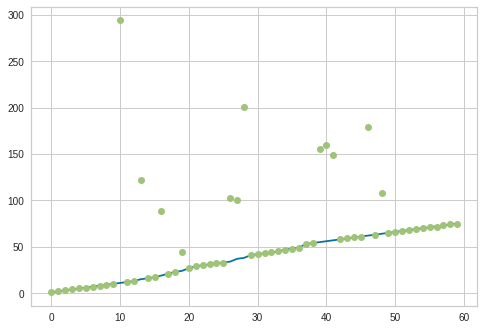

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_train)
plt.plot(y_test, 'o')
plt.show()

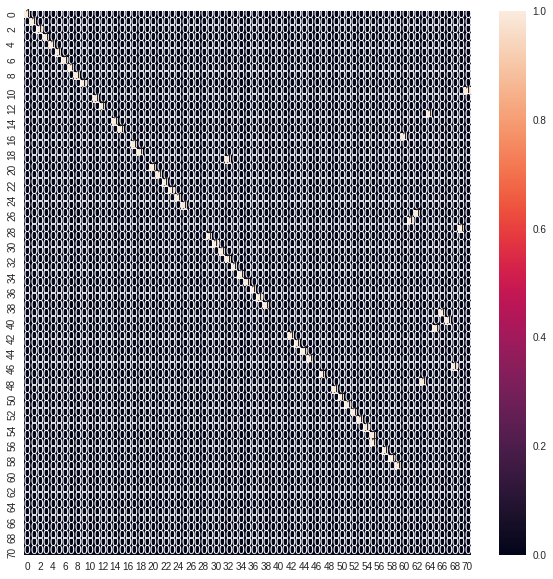

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(cm , annot=True)

In [ ]:
y_teste = y['n'].tolist()
y_train = y['BERT-AUGM'].tolist()

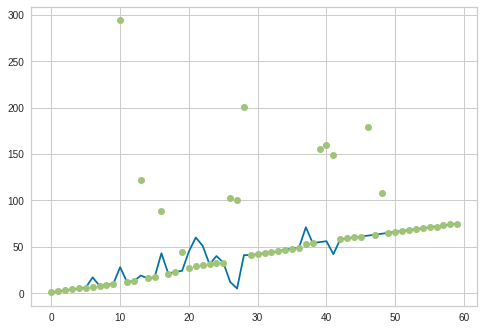

In [ ]:
import matplotlib.pyplot as plt
y_teste = y['n'].tolist()
y_train = y['BERT-AUGM'].tolist()
plt.plot(y_train)
plt.plot(y_test, 'o')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f1_score(y_teste, y_train, average="macro"))
print(precision_score(y_teste, y_train, average="macro"))
print(recall_score(y_teste, y_train, average="macro"))    

0.6422222222222221
0.611111111111111
0.7066666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


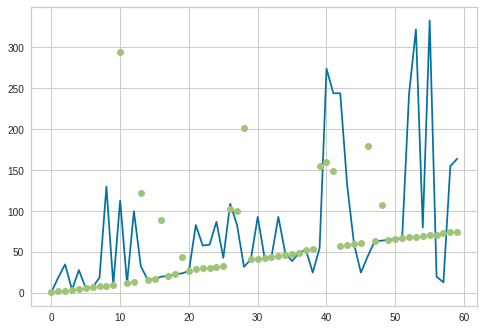

In [ ]:
y_teste = y['n'].tolist()
y_train = y['BM25'].tolist()
plt.plot(y_train)
plt.plot(y_test, 'o')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_train, y_test)
print (cm)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


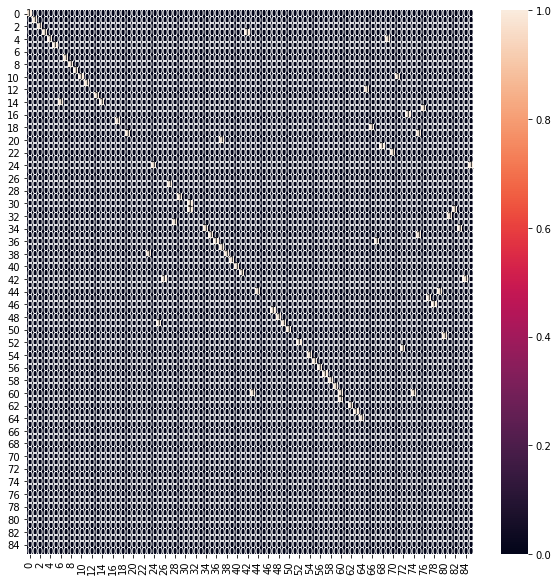

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(cm , annot=True)

In [ ]:
y_teste = y['n'].tolist()
y_train = y['BM25'].tolist()

In [ ]:
print(f1_score(y_teste, y_train, average="macro"))
print(precision_score(y_teste, y_train, average="macro"))
print(recall_score(y_teste, y_train, average="macro"))    

0.274822695035461
0.2641843971631206
0.2978723404255319


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_train, y_test)
print (cm)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


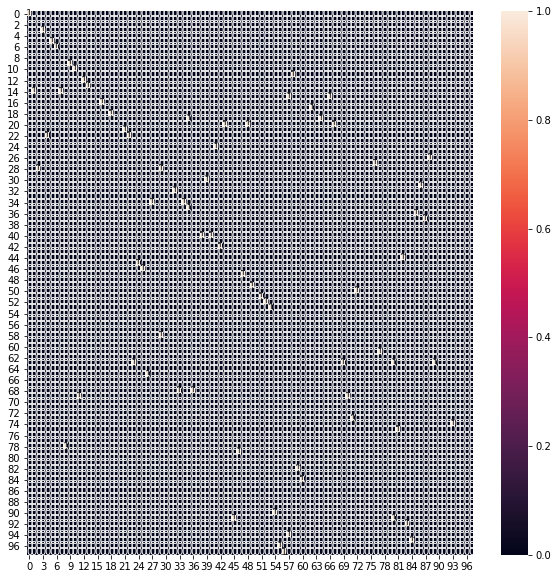

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(cm , annot=True)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd

In [ ]:
!pip install nltk

In [ ]:
from nltk.metrics import ConfusionMatrix

In [ ]:
y = pd.read_csv('/content/drive/MyDrive/Data_PHD/sent - sent.csv')

In [ ]:
y

,n,question,resposta,BERT-AUGM in domain,BERT_AUGM_TFIDF,BERT+BM25,HOPE_model
0,1,Posso beber bebida alcólica?,Não consumir álcool,1,1,1,1
1,2,Quais alimentos devo comer?,Os alimentos selecionados devem ser do hábito ...,74,2,2,2
2,3,O que é um plano de parto?,O plano de parto é um documento elaborado pela...,293,3,3,3
3,4,Frutas fazem bem?,"No Sudeste, frutas à tarde e feijão à noite fa...",4,4,4,4
4,5,Qual sua opinião sobre bacon?,"Evitar bacon,frios e todos os dias.",4,5,2,5
5,6,Qual a relação de leite e derivados,"Leite e Derivados\n \nSão ricos em cálcio e, p...",90,6,6,6
6,7,Quais as chances de eu ter anemia?,A anemia é altamente prevalente em todas as re...,7,7,7,7
7,8,o exercício físico pode atrapalhar,Atividade física e profissional: Exercícios mu...,8,10,8,8
8,9,Por quanto tempo fzer exercicios?,Quantas vezes devo fazer exercício? Você deve ...,9,12,9,9
9,10,Como é uma alimentação saudavel?,"Para uma alimentação saudável, deve-se usar al...",10,10,10,10


In [ ]:
y_test= y['n'].tolist()
y_pred = y['BERT-AUGM in domain'].tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))   

0.572139303482587
0.5547263681592041
0.6119402985074627


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')


In [ ]:
y_test= y['n'].tolist()
y_pred = y['HOPE_model'].tolist()

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))  

0.7562189054726368
0.753731343283582
0.7611940298507462


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')


In [ ]:
y_test= y['n'].tolist()
y_pred = y['BERT_AUGM_TFIDF'].tolist()

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.474537037037037
0.45601851851851843
0.5138888888888888


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')


In [ ]:
y_test= y['n'].tolist()
y_pred = y['BERT+BM25'].tolist()

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.5771144278606966
0.5597014925373134
0.6119402985074627


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  average_options = (None, 'micro', 'macro', 'weighted', 'samples')


In [ ]:
BERTimbau_Augmented = [ 0.186,0.206,	0.211,	0.284,	0.384]
BERTImbau_augmented_BM25= [ 0.198,	0.269,	0.226,	0.382,	0.432]
BERTImbau_augmented_TFIDF= [ 0.280,	0.222,	0.289,	0.300, 0.500]
Hope_Model  = [ 0.202, 0.204, 	0.256, 	0.344, 	0.448	]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({ 'BERTimbau_Augmented': BERTimbau_Augmented, 'BERTImbau_augmented_BM25': BERTImbau_augmented_BM25, 'Bertimbau_augmented_tfidf':BERTImbau_augmented_TFIDF, 'Hope Model ': Hope_Model})
 
# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Create a color palette
palette = plt.get_cmap('Set1')
 
# Plot multiple lines


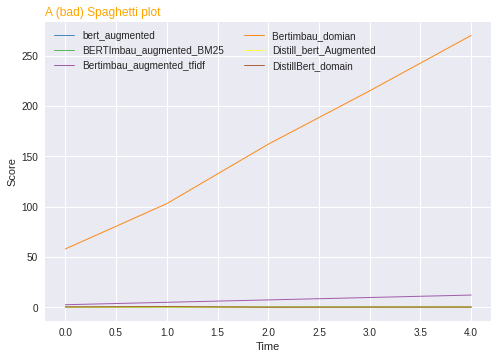

In [ ]:
num=0
for column in df:
    num+=1
    plt.plot(df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")

# Show the graph
plt.show()

In [ ]:
df

,BERTimbau_Augmented,BERTImbau_augmented_BM25,Bertimbau_augmented_tfidf,Hope Model
0,0.186,0.198,0.280,0.202
1,0.206,0.269,0.222,0.204
2,0.211,0.226,0.289,0.256
3,0.284,0.382,0.300,0.344
4,0.384,0.432,0.500,0.448


In [ ]:
s = (0.202 + 0.204 + 0.256 +	0.344 +	0.448)

In [ ]:
s

1.454

In [ ]:
s1 = (0.186 + 0.206 +	0.211 +0.284 +0.384)

In [ ]:
s1/5

0.2542

In [ ]:
1.7/5

0.33999999999999997

Text(0, 0.5, 'Seconds')

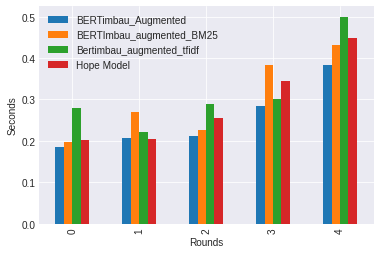

In [ ]:
df.plot(kind="bar")

plt.xlabel("Rounds")
plt.ylabel("Seconds")

In [ ]:
Augmented_BERTimbau = [30,	30,	40,	45]
BERTimbau_domain= [ 10,	15, 20,	35]
Augmented_DistilBert_multilingual = [ 15,	25,	35,	40]
DistillBert_domain  = [ 12,	10, 25,	35]

In [ ]:
import pandas as pd
df=pd.DataFrame({ 'Augmented_BERTimbau': Augmented_BERTimbau, 'BERTimbau_domain':BERTimbau_domain, 'Augmented_DistilBert_multilingual': Augmented_DistilBert_multilingual, 'DistillBert_domain': DistillBert_domain  })

In [ ]:
df

,Augmented_BERTimbau,BERTimbau_domain,Augmented_DistilBert_multilingual,DistillBert_domain
0,30,10,15,12
1,30,15,25,10
2,40,20,35,25
3,45,35,40,35


In [ ]:
idx = 0
new_col = [2, 3, 6, 10]  # can be a list, a Series, an array or a scalar   
df.insert(loc=idx, column='Recall', value=new_col)

In [ ]:
df_ = df.set_index('Recall')

In [ ]:
df_

,Augmented_BERTimbau,BERTimbau_domain,Augmented_DistilBert_multilingual,DistillBert_domain
Recall,,,,
2,30,10,15,12
3,30,15,25,10
6,40,20,35,25
10,45,35,40,35


Text(0, 0.5, 'Recall@K')

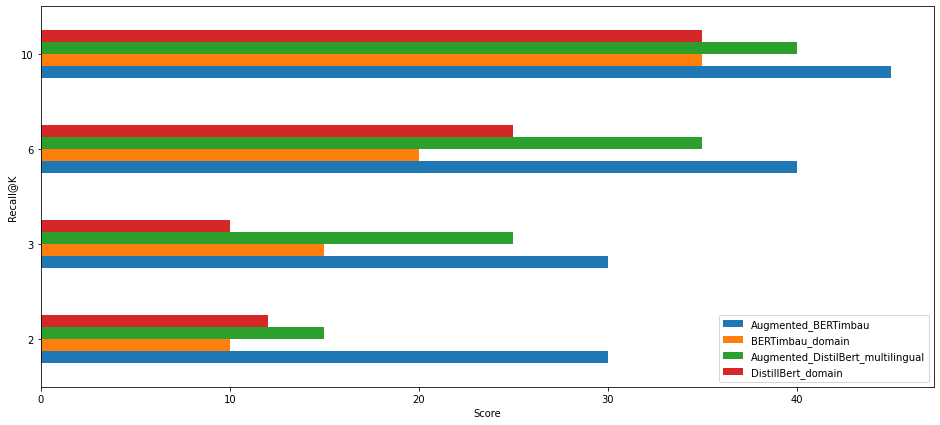

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))
df_.plot(kind='barh', legend = True, ax=ax)
ax.set_xlabel('Score')
ax.set_ylabel('Recall@K')